In [4]:
#### Imports para entrenamiento, predicción y evaluación del modelo ####
#### NO QUITAR ####
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
#### Código Agregado ####
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from wordcloud import WordCloud
%matplotlib inline
sns.set_style('darkgrid')

In [5]:
### Loading Data
data_file_path = '/home/mgarcia/Documents/Study/DiploDatos/Exercises/Integrators/Integrator_1/data.csv'
tag_file_path = '/home/mgarcia/Documents/Study/DiploDatos/Exercises/Integrators/Integrator_1/tag.csv'
data = pd.read_csv(data_file_path)
tag = pd.read_csv(tag_file_path)

In [6]:
pd.set_option('display.max_columns',30)

In [7]:
data.head(5)

,SUSCRIBER_KEY,FECHA_CORTE,LAT_PROV_BTS,LON_PROV_BTS,LAT_CITY_BTS,LON_CITY_BTS,VALUE_SEGMENT,SEGMENTATION,MICROSEGMENTATION,SOURCE,DEVICE_MODEL_NAME,DEVICE_VENDOR_NAME,NETWORK_TECH,COMMERCIAL_ACTIVATION_DATE,TENURE_CUSTOMER,...,PACK_SMS_AMT_W10,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_DATA_EXP_W1,PACK_DATA_EXP_W2,PACK_DATA_EXP_W3,PACK_DATA_EXP_W4,PACK_DATA_EXP_W5,PACK_DATA_EXP_W6,PACK_DATA_EXP_W7,PACK_DATA_EXP_W8,PACK_DATA_EXP_W9,PACK_DATA_EXP_W10,PACK_DATA_EXP_W11,PACK_DATA_EXP_W12
0,E_63734494_20190215,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,3 - SILVER,2-PD,PD1,NEW,G4 STYLUS (H540),LG,LTE,15-FEB-19,8,...,0.0,0.0,0.0,0,0,5,6,10,11,0,4,11,0,0,0
1,E_66977552_20190518,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,4 - BRONZE,7-LOW,LOW3,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,NaN,18-MAY-19,5,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
2,E_69159695_20180116,08-SEP-19,8.1231,-81.0755,-78.16140,8.65525,3 - SILVER,6-OH,LOW4,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,3G,16-JAN-18,21,...,0.0,0.0,0.0,7,6,13,10,4,11,0,0,0,0,9,0
3,E_65255730_20190416,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,7-LOW,LOW3,NEW,JENNY TV 2.8,BLU,LTE,16-APR-19,6,...,0.0,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0
4,E_67893872_20161201,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,3-DO,DO3,NEW,GALAXY J1 (SM-J111MDS),SAMSUNG,LTE,01-DEC-16,35,...,0.0,0.0,0.0,0,4,11,18,7,14,13,20,27,34,7,14


## Limpiando el target

 Sacamos las columnas que no nos van a hacer falta, ya que queremos predecir si cargará o no

In [8]:
tag.drop(columns=[x for x in tag.columns if 'AMT' in x],inplace=True)

Sumaremos todas las cargas que realizaron

In [9]:
tag['Total'] = tag[tag.columns[1:]].sum(axis=1)

In [10]:
tag.drop(columns=[x for x in tag.columns if 'EVT' in x],inplace=True)

Reemplazamos la cantidad de cargar por "False" si cargó, y "True" si no cargó 

In [11]:
tag['Total']= tag['Total']==0

In [12]:
tag.rename(columns={'Total':'Target'},inplace=True)

In [13]:
tag['Target'] = tag['Target'].astype(int)

 Unimos los datasets

In [14]:
fulldata = data.merge(tag, on='SUSCRIBER_KEY')

In [15]:
del tag
del data

 # Limpieza de columnas 

Todas las que dicen en el documento 'No se usa'

In [16]:
fulldata.drop(columns=[x for x in fulldata.columns if 'ARPU' in x],inplace=True)

Quedaron 5 a eliminar (quedaban 190 después de que el profe eliminó las innecesarias)

In [17]:
que_quedaron= ["USE_LCL_VOI_AMT_M1", "USE_LCL_VOI_AMT_M2","USE_LCL_VOI_AMT_M3",]

In [18]:
fulldata.drop(columns=que_quedaron,inplace=True)

In [19]:
fulldata.shape

(319222, 192)

Removemos columnas que tienen un solo valor 

In [20]:
columnas_a_eliminar = [x for x in fulldata.columns if fulldata[x].nunique()==1]

In [21]:
fulldata.drop(columns=columnas_a_eliminar, inplace=True)

In [22]:
fulldata.shape

(319222, 190)

## Veamos ahora los nulos

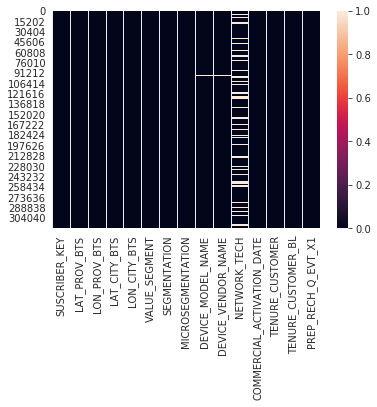

In [23]:
sns.heatmap(fulldata[fulldata.columns[0:15]].isnull())

In [24]:
nullcount = {col:fulldata[col].isnull().sum() for col in fulldata.columns}

Hasta ahí los nulos eran una lista. Ahora con pandas los convertimos en un array

In [25]:
missing = pd.Series(nullcount)

In [26]:
missing

SUSCRIBER_KEY          0
LAT_PROV_BTS         734
LON_PROV_BTS         734
LAT_CITY_BTS         734
LON_CITY_BTS         734
                    ... 
PACK_DATA_EXP_W9       0
PACK_DATA_EXP_W10      0
PACK_DATA_EXP_W11      0
PACK_DATA_EXP_W12      0
Target                 0
Length: 190, dtype: int64

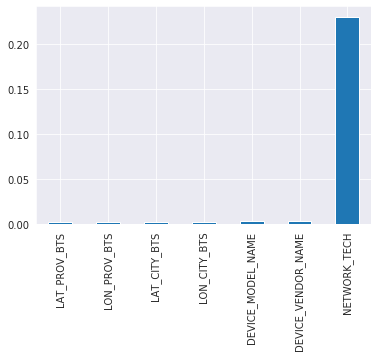

In [32]:
missing[missing>0].div(fulldata.shape[0]).plot.bar()

---

# Limpieza de datos categóricos

---

Analizamos los datos categoricos

In [27]:
fulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319222 entries, 0 to 319221
Columns: 190 entries, SUSCRIBER_KEY to Target
dtypes: float64(82), int64(98), object(10)
memory usage: 465.2+ MB


In [28]:
cols = fulldata.columns 
num_cols = fulldata._get_numeric_data().columns 
cat_columns = list(set(cols) - set(num_cols))

In [29]:
cat_columns

['DEVICE_MODEL_NAME',
 'PREP_RECH_LAST_DAY_12W',
 'NETWORK_TECH',
 'VALUE_SEGMENT',
 'SEGMENTATION',
 'COMMERCIAL_ACTIVATION_DATE',
 'PREP_RECH_CHNNL_MODE12W',
 'DEVICE_VENDOR_NAME',
 'SUSCRIBER_KEY',
 'MICROSEGMENTATION']

In [30]:
Cat_fulldata =  fulldata[cat_columns].copy()

In [31]:
Cat_fulldata.head(5)

,DEVICE_MODEL_NAME,PREP_RECH_LAST_DAY_12W,NETWORK_TECH,VALUE_SEGMENT,SEGMENTATION,COMMERCIAL_ACTIVATION_DATE,PREP_RECH_CHNNL_MODE12W,DEVICE_VENDOR_NAME,SUSCRIBER_KEY,MICROSEGMENTATION
0,G4 STYLUS (H540),19-AUG-19,LTE,3 - SILVER,2-PD,15-FEB-19,"N/A,3;UGW,9",LG,E_63734494_20190215,PD1
1,NOT_IDENTIFIED,03-JUL-19,NaN,4 - BRONZE,7-LOW,18-MAY-19,"UGW,1",NOT_IDENTIFIED,E_66977552_20190518,LOW3
2,NOT_IDENTIFIED,02-SEP-19,3G,3 - SILVER,6-OH,16-JAN-18,"N/A,3;UGW,4",NOT_IDENTIFIED,E_69159695_20180116,LOW4
3,JENNY TV 2.8,01-SEP-19,LTE,3 - SILVER,7-LOW,16-APR-19,"UGW,2",BLU,E_65255730_20190416,LOW3
4,GALAXY J1 (SM-J111MDS),05-SEP-19,LTE,3 - SILVER,3-DO,01-DEC-16,"N/A,1;UGW,4",SAMSUNG,E_67893872_20161201,DO3


Logramos identificar que las columas network tech, device vendor model y device vendor name tienen valores nulos ya sea como 'NaN' o como 'NOT_IDENTIFIED'. Por eso decidimos imputarlos..

## Imputar network tech

In [38]:
fulldata['NETWORK_TECH'].value_counts(normalize=True,dropna=False)

LTE    0.697358
3G     0.272118
2G     0.030524
Name: NETWORK_TECH, dtype: float64

Vemos que dentro de los valores tenemos un 22% que son NaN

In [39]:
fulldata['NETWORK_TECH'].value_counts(dropna=False)

LTE    222612
3G      86866
2G       9744
Name: NETWORK_TECH, dtype: int64

Calculamos la moda de la columna NETWORK_TECH para luego reemplazarla por los valores NaN

In [40]:
moda_network_tech=fulldata['NETWORK_TECH'].mode()
moda_network_tech[0]

'LTE'

In [41]:
fulldata['NETWORK_TECH'].fillna(moda_network_tech[0], inplace=True)

In [42]:
fulldata['NETWORK_TECH'].value_counts(normalize=True,dropna=False)

LTE    0.697358
3G     0.272118
2G     0.030524
Name: NETWORK_TECH, dtype: float64

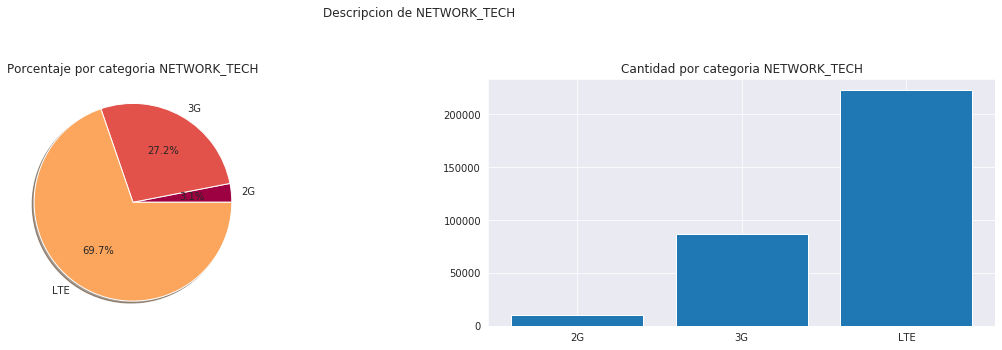

In [43]:
pie_labels=fulldata['NETWORK_TECH'].sort_values().unique()
pie_data_cantidad=fulldata['NETWORK_TECH'].value_counts(dropna=False).sort_values()
pie_data_porcentaje=fulldata['NETWORK_TECH'].value_counts(normalize=True,dropna=False).sort_values()
#explode= (0,0.1,0)
plt.figure(1,figsize=(20,10))
the_grid=GridSpec(2,2)
cmap = plt.get_cmap('Spectral')
colors=[cmap(i) for i in np.linspace(0,1,8)]
#Grafico de cantidades de NETWORK_TECH
plt.subplot(the_grid[0,1], title='Cantidad por categoria NETWORK_TECH')
cantidades_pie=plt.bar(pie_labels ,pie_data_cantidad)
#Grafico de porcentajes de NETWORK_TECH
plt.subplot(the_grid[0,0], title='Porcentaje por categoria NETWORK_TECH')
porcentaje_pie=plt.pie(pie_data_porcentaje, labels=pie_labels, autopct='%1.1f%%', shadow=True, colors=colors)

plt.suptitle('Descripcion de NETWORK_TECH')

plt.show()

Vemos que el 22% de NaN paso a LTE 

## Imputar device model name

In [44]:
fulldata['DEVICE_MODEL_NAME'].value_counts(normalize=True,dropna=False)

NOT_IDENTIFIED                           0.134881
GALAXY GRAND PRIME DUOS (SM-G532M DS)    0.105281
GALAXY GRAND NEO (GT-I9060C)             0.029039
GALAXY J7 DUOS LTE (SM-J700MDS)          0.023892
Y5 2018 (DRA-LX3)                        0.020807
                                           ...   
GALAXY A3 (SM-A300M)                     0.000003
GT-S3570                                 0.000003
A83T                                     0.000003
8 SIROCCO (TA-1005)                      0.000003
3V (5099A)                               0.000003
Name: DEVICE_MODEL_NAME, Length: 2477, dtype: float64

Vemos que el 13% de los datos de la columna DEVICE_MODEL_NAME son 'NOT_IDENTIFIED', con lo cual procedemos a inputar los datos por el valor de la moda.

In [45]:
device_model_name=fulldata[fulldata['DEVICE_MODEL_NAME']!='NOT_IDENTIFIED']
moda_device_model_name=device_model_name.DEVICE_MODEL_NAME.mode()
moda_device_model_name[0]

'GALAXY GRAND PRIME DUOS (SM-G532M DS)'

In [46]:
fulldata['DEVICE_MODEL_NAME'].replace({'NOT_IDENTIFIED':moda_device_model_name[0]},inplace=True)

In [47]:
fulldata['DEVICE_MODEL_NAME'].fillna(moda_device_model_name[0], inplace=True)

In [48]:
fulldata['DEVICE_MODEL_NAME'].value_counts(normalize=True,dropna=False)

GALAXY GRAND PRIME DUOS (SM-G532M DS)    0.242916
GALAXY GRAND NEO (GT-I9060C)             0.029039
GALAXY J7 DUOS LTE (SM-J700MDS)          0.023892
Y5 2018 (DRA-LX3)                        0.020807
GALAXY J2 PRIME (SM-G532M)               0.020259
                                           ...   
GALAXY A3 (SM-A300M)                     0.000003
GT-S3570                                 0.000003
A83T                                     0.000003
8 SIROCCO (TA-1005)                      0.000003
A50                                      0.000003
Name: DEVICE_MODEL_NAME, Length: 2475, dtype: float64

Vemos que los valores de 'NOT_IDENTIFIED' se reemplazaron por la moda.

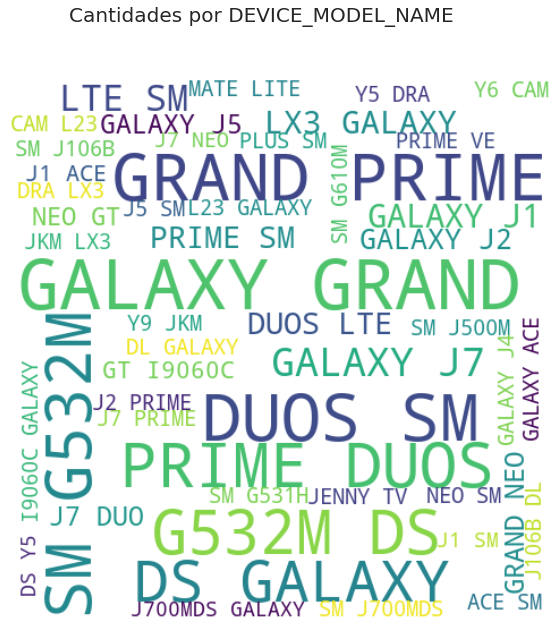

In [49]:
text=' '.join(fulldata['DEVICE_MODEL_NAME'])
# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0, background_color="white",max_words=50).generate(text)

plt.figure(1,figsize=(20,10))
the_grid=GridSpec(1,1)
plt.subplot(the_grid[0,0])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.suptitle('Cantidades por DEVICE_MODEL_NAME', fontsize=20)
plt.show()


## Imputar device vendor name

In [51]:
fulldata['DEVICE_VENDOR_NAME'].value_counts(normalize=True,dropna=False)

SAMSUNG           0.502356
HUAWEI            0.173418
NOT_IDENTIFIED    0.134881
LG                0.051610
BLU               0.030712
                    ...   
G-TIDE            0.000003
MOBO              0.000003
SEIKO             0.000003
OPTION            0.000003
HTW               0.000003
Name: DEVICE_VENDOR_NAME, Length: 234, dtype: float64

Vemos que el 13% de los datos de la columna DEVICE_V.ENDOR_NAME son 'NOT_IDENTIFIED', por lo que procedemos a reemplazar los valores por la moda 

In [52]:
device_vendor_name=fulldata[fulldata['DEVICE_VENDOR_NAME']!='NOT_IDENTIFIED']
moda_device_vendor_name=device_vendor_name.DEVICE_VENDOR_NAME.mode()
moda_device_vendor_name[0]

'SAMSUNG'

In [54]:
fulldata['DEVICE_VENDOR_NAME'].replace({'NOT_IDENTIFIED':moda_device_vendor_name[0]},inplace=True)
fulldata['DEVICE_VENDOR_NAME'].fillna(moda_device_vendor_name[0], inplace=True)
fulldata['DEVICE_VENDOR_NAME'].value_counts(normalize=True,dropna=False)

SAMSUNG    0.639990
HUAWEI     0.173418
LG         0.051610
BLU        0.030712
NOKIA      0.026953
             ...   
ZOPO       0.000003
GFEN       0.000003
SEIKO      0.000003
G-TIDE     0.000003
HTW        0.000003
Name: DEVICE_VENDOR_NAME, Length: 232, dtype: float64

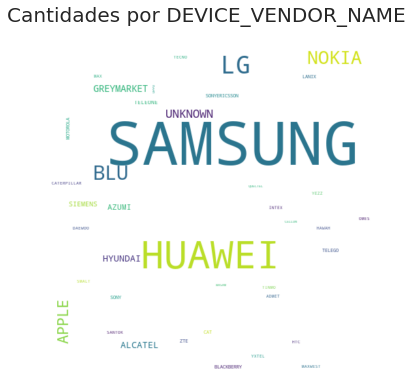

In [60]:
text=' '.join(fulldata['DEVICE_VENDOR_NAME'])
# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0, background_color="white",max_words=40).generate(text)
plt.figure(figsize=(6,6))
the_grid=GridSpec(1,1)
plt.subplot(the_grid[0,0])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.suptitle('Cantidades por DEVICE_VENDOR_NAME', fontsize=20)
plt.show()


Los valores de NOT_IDENTIFIED fueron reemplazados por su moda, que en este caso es 'SAMSUNG'.

---

# Limpieza de datos numéricos

---

Ahora procedemos a limpiar los datos numericos, para esto separamos el data set en datos referidos a las recargas, pack y a trafico de datos.

## Limpieza de datos de Pack

Primero separamos las columnas que son de datos referidos a los packs

In [61]:
Pack_columns=['SUSCRIBER_KEY']
for a in cols:
    if a.startswith('PACK_'):
        Pack_columns.append(a)

In [62]:
Pack_fulldata=fulldata[Pack_columns]
Pack_fulldata

,SUSCRIBER_KEY,PACK_DATA_Q_X1,PACK_DATA_Q_X2,PACK_DATA_Q_X3,PACK_DATA_AMT_X1,PACK_DATA_AMT_X2,PACK_DATA_AMT_X3,PACK_VOICE_Q_X1,PACK_VOICE_Q_X2,PACK_VOICE_Q_X3,PACK_VOICE_AMT_X1,PACK_VOICE_AMT_X2,PACK_VOICE_AMT_X3,PACK_SMS_Q_X1,PACK_SMS_Q_X2,...,PACK_SMS_AMT_W10,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_DATA_EXP_W1,PACK_DATA_EXP_W2,PACK_DATA_EXP_W3,PACK_DATA_EXP_W4,PACK_DATA_EXP_W5,PACK_DATA_EXP_W6,PACK_DATA_EXP_W7,PACK_DATA_EXP_W8,PACK_DATA_EXP_W9,PACK_DATA_EXP_W10,PACK_DATA_EXP_W11,PACK_DATA_EXP_W12
0,E_63734494_20190215,4,5,4,6.00,9.0,6.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,5,6,10,11,0,4,11,0,0,0
1,E_66977552_20190518,0,0,0,0.00,0.0,0.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
2,E_69159695_20180116,5,3,3,4.50,3.0,1.50,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,7,6,13,10,4,11,0,0,0,0,9,0
3,E_65255730_20190416,3,0,0,0.99,0.0,0.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0
4,E_67893872_20161201,3,4,3,8.99,9.0,10.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,4,11,18,7,14,13,20,27,34,7,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,E_66690182_20190121,0,0,4,0.00,0.0,4.99,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,3,10,0
319218,E_65347728_20171017,3,5,7,3.00,6.0,10.48,4,4,7,3.98,3.98,9.95,0,0,...,0.0,0.0,0.0,0,0,0,8,9,0,4,11,10,7,13,7
319219,E_68063707_20150701,0,0,0,0.00,0.0,0.00,0,3,0,0.00,1.99,0.00,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
319220,E_67206080_20181010,0,0,3,0.00,0.0,5.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,5,12


Comparamos las columnas de pack semanal contra las mensuales para buscar datos incorrectos o verificar si la informacion es duplicada.

### Para la cantidad de pack de datos :

In [63]:
Pack_fulldata[['PACK_DATA_Q_W1','PACK_DATA_Q_W2','PACK_DATA_Q_W3','PACK_DATA_Q_W4','PACK_DATA_Q_X1','PACK_DATA_Q_W5','PACK_DATA_Q_W6','PACK_DATA_Q_W7','PACK_DATA_Q_W8','PACK_DATA_Q_X2','PACK_DATA_Q_W9','PACK_DATA_Q_W10','PACK_DATA_Q_W11','PACK_DATA_Q_W12','PACK_DATA_Q_X3']]

,PACK_DATA_Q_W1,PACK_DATA_Q_W2,PACK_DATA_Q_W3,PACK_DATA_Q_W4,PACK_DATA_Q_X1,PACK_DATA_Q_W5,PACK_DATA_Q_W6,PACK_DATA_Q_W7,PACK_DATA_Q_W8,PACK_DATA_Q_X2,PACK_DATA_Q_W9,PACK_DATA_Q_W10,PACK_DATA_Q_W11,PACK_DATA_Q_W12,PACK_DATA_Q_X3
0,0,0,3,3,4,3,4,0,0,5,4,0,0,0,4
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,3,3,5,0,3,0,0,3,0,0,3,0,3
3,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,3,3,0,3,0,3,4,0,3,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0,0,0,0,0,0,0,0,0,0,0,0,4,0,4
319218,0,0,0,3,3,3,0,0,4,5,3,3,4,3,7
319219,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319220,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3


Vemos que hay inconsistencias entre las cantidades semanales y las mensuales, por ende la informacion es incorrecta.
Eliminamos las columnas con la premisa de no meter basura en el modelo.

In [64]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_DATA_Q' in x],inplace=True)

### Para los montos de pack de datos:

In [65]:
Pack_fulldata[['PACK_DATA_AMT_W1','PACK_DATA_AMT_W2','PACK_DATA_AMT_W3','PACK_DATA_AMT_W4','PACK_DATA_AMT_X1','PACK_DATA_AMT_W5','PACK_DATA_AMT_W6','PACK_DATA_AMT_W7','PACK_DATA_AMT_W8','PACK_DATA_AMT_X2','PACK_DATA_AMT_W9','PACK_DATA_AMT_W10','PACK_DATA_AMT_W11','PACK_DATA_AMT_W12','PACK_DATA_AMT_X3']]


,PACK_DATA_AMT_W1,PACK_DATA_AMT_W2,PACK_DATA_AMT_W3,PACK_DATA_AMT_W4,PACK_DATA_AMT_X1,PACK_DATA_AMT_W5,PACK_DATA_AMT_W6,PACK_DATA_AMT_W7,PACK_DATA_AMT_W8,PACK_DATA_AMT_X2,PACK_DATA_AMT_W9,PACK_DATA_AMT_W10,PACK_DATA_AMT_W11,PACK_DATA_AMT_W12,PACK_DATA_AMT_X3
0,0.0,0.0,3.00,3.00,6.00,3.0,6.0,0.0,0.0,9.0,6.0,0.0,0.00,0.00,6.00
1,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
2,1.5,0.0,1.50,1.50,4.50,0.0,3.0,0.0,0.0,3.0,0.0,0.0,1.50,0.00,1.50
3,0.0,0.0,0.99,0.00,0.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
4,0.0,0.0,0.00,8.99,8.99,0.0,5.0,0.0,4.0,9.0,0.0,10.0,0.00,0.00,10.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.99,0.00,4.99
319218,0.0,0.0,0.00,3.00,3.00,1.5,0.0,0.0,4.5,6.0,1.5,1.5,4.50,2.98,10.48
319219,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
319220,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,5.00,5.00


En este caso vemos que las columnas de montos mensuales coinciden con los montos semanales, por ende tener las 3 columnas mensuales seria tener datos repetidos ya que esto lo podemos ver haciendo la suma de los montos semanales.
Eliminamos entonces las columnas de los montos acumulados mensuales para pack de datos.

In [66]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_DATA_AMT_X' in x],inplace=True)

Text(0.5, 1.0, 'Monto de pack de datos (Semana 9 a 12)')

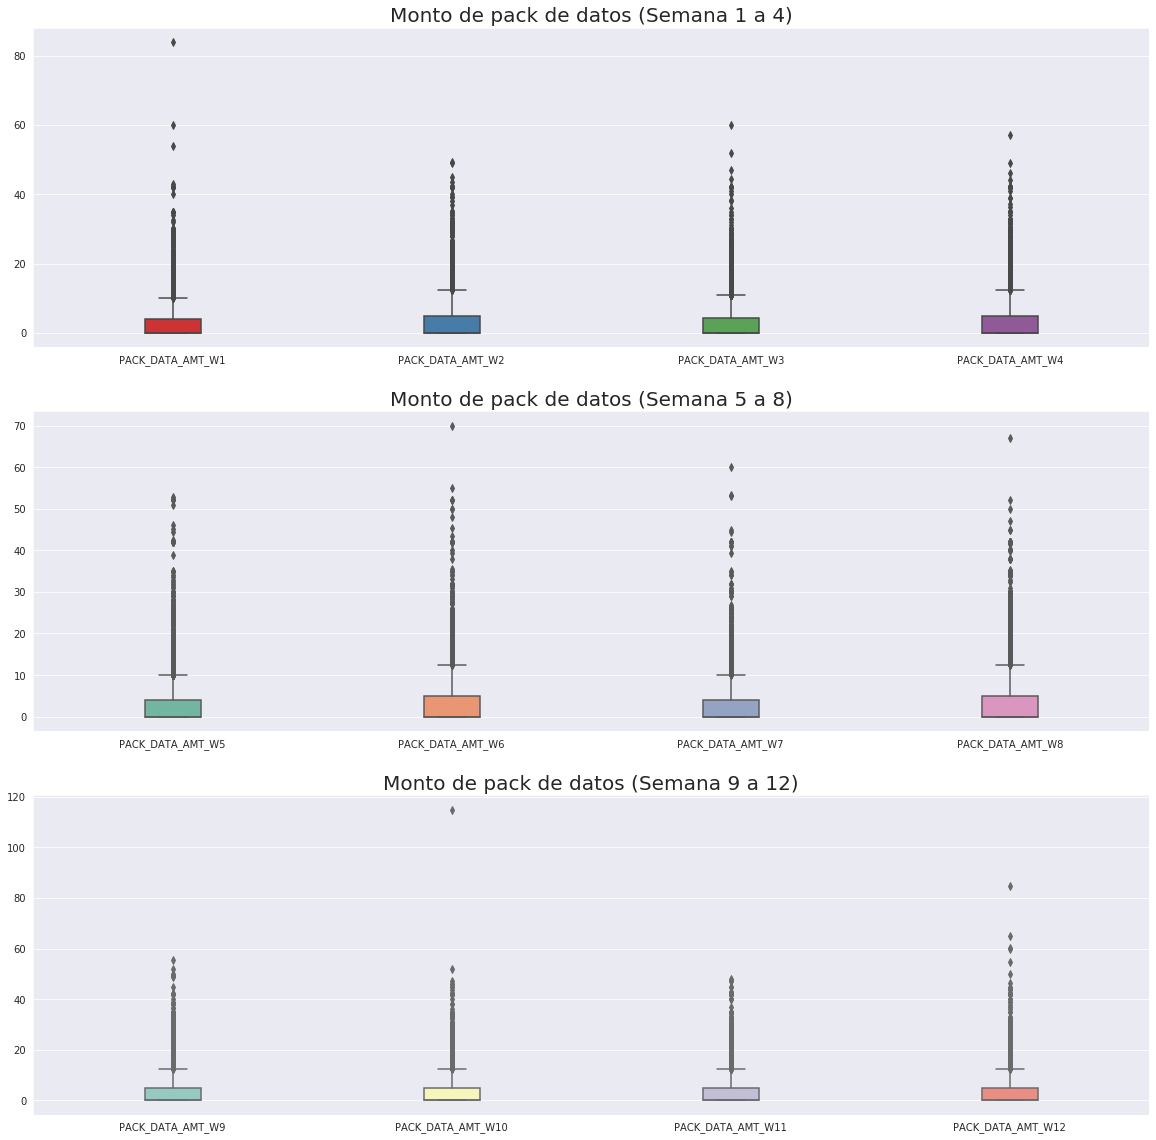

In [67]:
plt.figure(figsize=(20,20))

the_grid=GridSpec(3,1)
plt.subplot(the_grid[0,0])
data_to_box_plot1=Pack_fulldata[['PACK_DATA_AMT_W1','PACK_DATA_AMT_W2','PACK_DATA_AMT_W3','PACK_DATA_AMT_W4']]
a=sns.boxplot(data=data_to_box_plot1,orient="v", palette="Set1" ,width=0.2)
plt.subplot(the_grid[1,0])
data_to_box_plot2=Pack_fulldata[['PACK_DATA_AMT_W5','PACK_DATA_AMT_W6','PACK_DATA_AMT_W7','PACK_DATA_AMT_W8']]
b=sns.boxplot(data=data_to_box_plot2,orient="v", palette="Set2" ,width=0.2)
plt.subplot(the_grid[2,0])
data_to_box_plot3=Pack_fulldata[['PACK_DATA_AMT_W9','PACK_DATA_AMT_W10','PACK_DATA_AMT_W11','PACK_DATA_AMT_W12']]
c=sns.boxplot(data=data_to_box_plot3,orient="v", palette="Set3" ,width=0.2)

a.axes.set_title("Monto de pack de datos (Semana 1 a 4)",fontsize=20)
b.axes.set_title("Monto de pack de datos (Semana 5 a 8)",fontsize=20)
c.axes.set_title("Monto de pack de datos (Semana 9 a 12)",fontsize=20)

Vemos que tenemos outliers por lo que procedemos a la eliminacion de los mismos segun esten en el primer o tercer quartil y multiplicando por 1.5 

In [68]:
for column in fulldata[['PACK_DATA_AMT_W1','PACK_DATA_AMT_W2','PACK_DATA_AMT_W3','PACK_DATA_AMT_W4','PACK_DATA_AMT_W5','PACK_DATA_AMT_W6','PACK_DATA_AMT_W7','PACK_DATA_AMT_W8','PACK_DATA_AMT_W9','PACK_DATA_AMT_W10','PACK_DATA_AMT_W11','PACK_DATA_AMT_W12']]:
    Q1 = fulldata[column].quantile(0.25)
    Q3 = fulldata[column].quantile(0.75)
    IQR = Q3 - Q1
    fulldata[column] = np.where((fulldata[column] < (Q1 - 1.5 * IQR)) | (fulldata[column] > (Q3 + 1.5 * IQR)), fulldata[column].median(), fulldata[column])


Text(0.5, 1.0, 'Monto de pack de datos (Semana 9 a 12)')

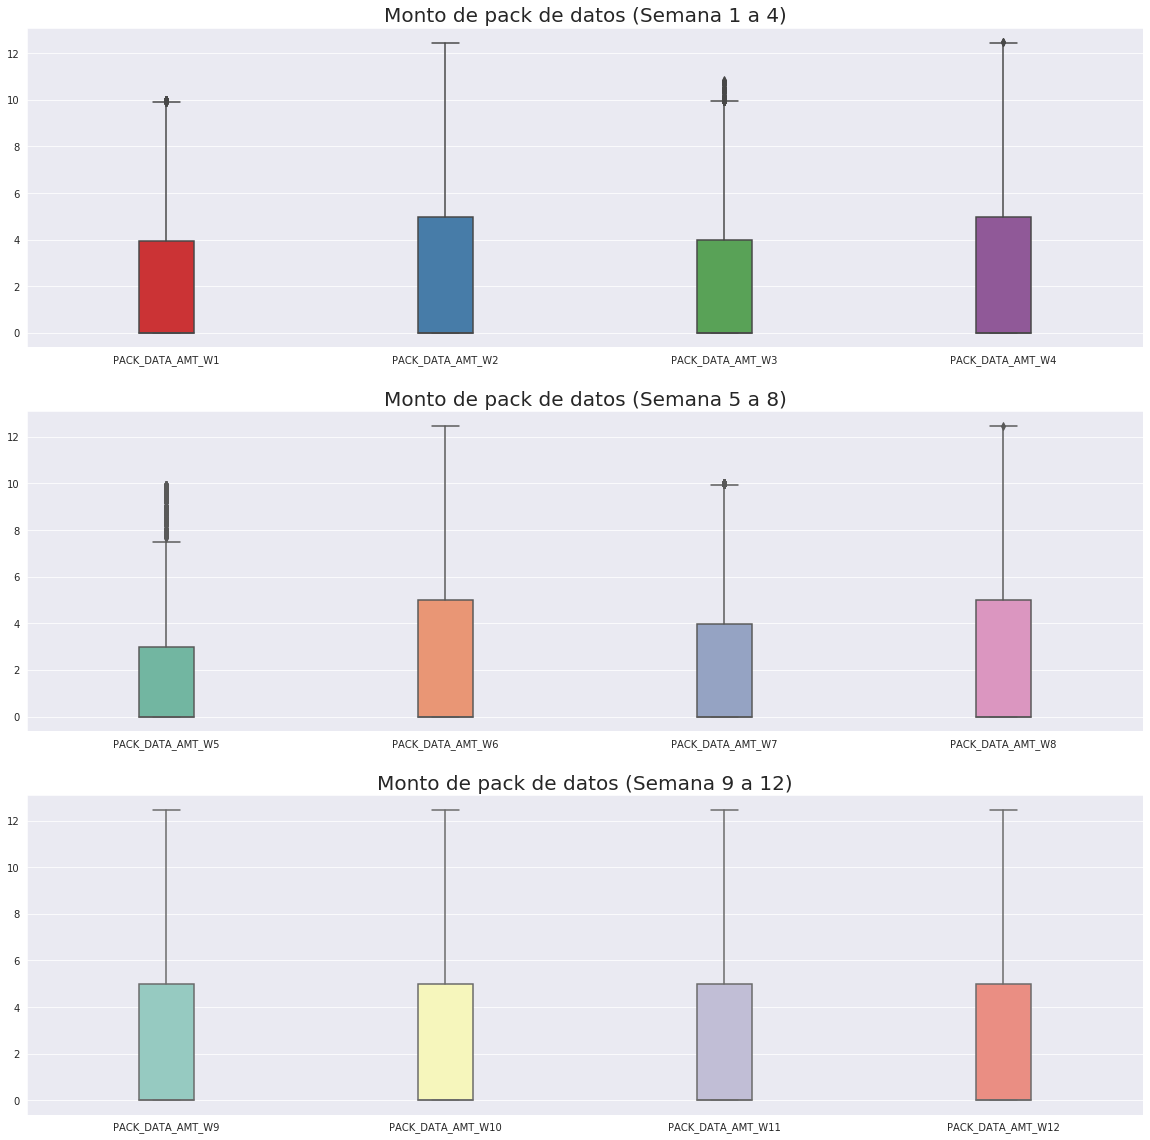

In [69]:
plt.figure(figsize=(20,20))

the_grid=GridSpec(3,1)
plt.subplot(the_grid[0,0])
data_to_box_plot1=fulldata[['PACK_DATA_AMT_W1','PACK_DATA_AMT_W2','PACK_DATA_AMT_W3','PACK_DATA_AMT_W4']]
a=sns.boxplot(data=data_to_box_plot1,orient="v", palette="Set1" ,width=0.2)
plt.subplot(the_grid[1,0])
data_to_box_plot2=fulldata[['PACK_DATA_AMT_W5','PACK_DATA_AMT_W6','PACK_DATA_AMT_W7','PACK_DATA_AMT_W8']]
b=sns.boxplot(data=data_to_box_plot2,orient="v", palette="Set2" ,width=0.2)
plt.subplot(the_grid[2,0])
data_to_box_plot3=fulldata[['PACK_DATA_AMT_W9','PACK_DATA_AMT_W10','PACK_DATA_AMT_W11','PACK_DATA_AMT_W12']]
c=sns.boxplot(data=data_to_box_plot3,orient="v", palette="Set3" ,width=0.2)

a.axes.set_title("Monto de pack de datos (Semana 1 a 4)",fontsize=20)
b.axes.set_title("Monto de pack de datos (Semana 5 a 8)",fontsize=20)
c.axes.set_title("Monto de pack de datos (Semana 9 a 12)",fontsize=20)


### Para la cantidad de pack de sms:

In [70]:
Pack_fulldata[['PACK_SMS_Q_W1','PACK_SMS_Q_W2','PACK_SMS_Q_W3','PACK_SMS_Q_W4','PACK_SMS_Q_X1','PACK_SMS_Q_W5','PACK_SMS_Q_W6','PACK_SMS_Q_W7','PACK_SMS_Q_W8','PACK_SMS_Q_X2','PACK_SMS_Q_W9','PACK_SMS_Q_W10','PACK_SMS_Q_W11','PACK_SMS_Q_W12','PACK_SMS_Q_X3']]

,PACK_SMS_Q_W1,PACK_SMS_Q_W2,PACK_SMS_Q_W3,PACK_SMS_Q_W4,PACK_SMS_Q_X1,PACK_SMS_Q_W5,PACK_SMS_Q_W6,PACK_SMS_Q_W7,PACK_SMS_Q_W8,PACK_SMS_Q_X2,PACK_SMS_Q_W9,PACK_SMS_Q_W10,PACK_SMS_Q_W11,PACK_SMS_Q_W12,PACK_SMS_Q_X3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319219,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319220,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Vemos que las columnas de los pack de sms semanales no coinciden con el correspondiente acumulado mensual, por lo que se considera dato incorrecto y se elimina del dataset.

In [71]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_SMS_Q' in x],inplace=True)

### Para los montos en sms:

In [72]:
Pack_fulldata[['PACK_SMS_AMT_W1','PACK_SMS_AMT_W2','PACK_SMS_AMT_W3','PACK_SMS_AMT_W4','PACK_SMS_AMT_X1','PACK_SMS_AMT_W5','PACK_SMS_AMT_W6','PACK_SMS_AMT_W7','PACK_SMS_AMT_W8','PACK_SMS_AMT_X2','PACK_SMS_AMT_W9','PACK_SMS_AMT_W10','PACK_SMS_AMT_W11','PACK_SMS_AMT_W12','PACK_SMS_AMT_X3']]

,PACK_SMS_AMT_W1,PACK_SMS_AMT_W2,PACK_SMS_AMT_W3,PACK_SMS_AMT_W4,PACK_SMS_AMT_X1,PACK_SMS_AMT_W5,PACK_SMS_AMT_W6,PACK_SMS_AMT_W7,PACK_SMS_AMT_W8,PACK_SMS_AMT_X2,PACK_SMS_AMT_W9,PACK_SMS_AMT_W10,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_SMS_AMT_X3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
319218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
319219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
319220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


En este caso los montos si coinciden, por lo cual se eliminan las columnas de acumulados para no repetir informacion.

In [73]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_SMS_AMT_X' in x],inplace=True)

### Para la cantidad de pack de voz:

In [74]:
Pack_fulldata[['PACK_VOICE_Q_W1','PACK_VOICE_Q_W2','PACK_VOICE_Q_W3','PACK_VOICE_Q_W4','PACK_VOICE_Q_X1','PACK_VOICE_Q_W5','PACK_VOICE_Q_W6','PACK_VOICE_Q_W7','PACK_VOICE_Q_W8','PACK_VOICE_Q_X2','PACK_VOICE_Q_W9','PACK_VOICE_Q_W10','PACK_VOICE_Q_W11','PACK_VOICE_Q_W12','PACK_VOICE_Q_X3']]

,PACK_VOICE_Q_W1,PACK_VOICE_Q_W2,PACK_VOICE_Q_W3,PACK_VOICE_Q_W4,PACK_VOICE_Q_X1,PACK_VOICE_Q_W5,PACK_VOICE_Q_W6,PACK_VOICE_Q_W7,PACK_VOICE_Q_W8,PACK_VOICE_Q_X2,PACK_VOICE_Q_W9,PACK_VOICE_Q_W10,PACK_VOICE_Q_W11,PACK_VOICE_Q_W12,PACK_VOICE_Q_X3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319218,0,0,0,4,4,3,0,0,3,4,0,4,0,5,7
319219,0,0,0,0,0,0,3,0,0,3,0,0,0,0,0
319220,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Aca vemos que las cantidades semanales no se corresponden con los acumulados mensuales, lo tomamos como valores incorrectos y procedemos a borrarlos

In [75]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_VOICE_Q' in x],inplace=True)


### Para el monto de pack de voz:

In [76]:
Pack_fulldata[['PACK_VOICE_AMT_W1','PACK_VOICE_AMT_W2','PACK_VOICE_AMT_W3','PACK_VOICE_AMT_W4','PACK_VOICE_AMT_X1','PACK_VOICE_AMT_W5','PACK_VOICE_AMT_W6','PACK_VOICE_AMT_W7','PACK_VOICE_AMT_W8','PACK_VOICE_AMT_X2','PACK_VOICE_AMT_W9','PACK_VOICE_AMT_W10','PACK_VOICE_AMT_W11','PACK_VOICE_AMT_W12','PACK_VOICE_AMT_X3']]

,PACK_VOICE_AMT_W1,PACK_VOICE_AMT_W2,PACK_VOICE_AMT_W3,PACK_VOICE_AMT_W4,PACK_VOICE_AMT_X1,PACK_VOICE_AMT_W5,PACK_VOICE_AMT_W6,PACK_VOICE_AMT_W7,PACK_VOICE_AMT_W8,PACK_VOICE_AMT_X2,PACK_VOICE_AMT_W9,PACK_VOICE_AMT_W10,PACK_VOICE_AMT_W11,PACK_VOICE_AMT_W12,PACK_VOICE_AMT_X3
0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
1,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
2,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
3,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
4,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
319218,0.0,0.0,0.0,3.98,3.98,1.99,0.00,0.0,1.99,3.98,0.0,3.98,0.0,5.97,9.95
319219,0.0,0.0,0.0,0.00,0.00,0.00,1.99,0.0,0.00,1.99,0.0,0.00,0.0,0.00,0.00
319220,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00


En este caso vemos que las columnas de montos mensuales coinciden con los montos semanales, por ende tener las 3 columnas mensuales seria tener datos repetidos ya que esto lo podemos ver haciendo la suma de los montos semanales.
Eliminamos entonces las columnas de los montos acumulados mensuales para pack de voz.

In [77]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_VOICE_AMT_X' in x],inplace=True)

In [78]:
fulldata.shape

(319222, 136)

---

## Limpieza de datos de tráfico

---

In [79]:
traffic_columns = [traffic_column for traffic_column in fulldata.columns if traffic_column.startswith("TR")]

In [80]:
len(traffic_columns)

33

#### Data frame solo con datos de tráfico

In [82]:
df_traffic = fulldata[traffic_columns].copy()

#### Corroborar si algun datao es NaN o null

In [83]:
any(df_traffic.isna().sum() != 0) or any(df_traffic.isnull().sum() != 0)

False

#### Selección de columnas

In [84]:
df_traffic.corr()

,TRD_M1,TRD_M2,TRD_M3,TRD_STR_M1,TRD_STR_M2,TRD_STR_M3,TRD_SN_M1,TRD_SN_M2,TRD_SN_M3,TRD_IM_M1,TRD_IM_M2,TRD_IM_M3,TRD_OTH_M1,TRD_OTH_M2,TRD_OTH_M3,...,TRS_OFFNET_SMS_M1,TRS_OFFNET_SMS_M2,TRS_OFFNET_SMS_M3,TRV_ONNET_DUR_M1,TRV_ONNET_DUR_M2,TRV_ONNET_DUR_M3,TRV_OFFNET_DUR_M1,TRV_OFFNET_DUR_M2,TRV_OFFNET_DUR_M3,TRV_LCL_DUR_M1,TRV_LCL_DUR_M2,TRV_LCL_DUR_M3,TRV_INTRNTL_DUR_M1,TRV_INTRNTL_DUR_M2,TRV_INTRNTL_DUR_M3
TRD_M1,1.000000,0.819897,0.706444,0.880530,0.686740,0.589018,0.680411,0.576677,0.504866,0.593411,0.502507,0.448108,-0.981298,-0.800250,-0.692806,...,-0.021242,-0.057533,-0.065129,0.159353,0.129310,0.107154,0.134440,0.102743,0.077624,0.169570,0.137804,0.113377,-0.000773,-0.002232,-0.004701
TRD_M2,0.819897,1.000000,0.812299,0.704101,0.849376,0.686593,0.568637,0.671875,0.563763,0.512410,0.595429,0.509747,-0.801601,-0.968443,-0.796362,...,-0.032868,-0.056186,-0.064748,0.133303,0.151496,0.121957,0.113338,0.122002,0.090125,0.141943,0.161491,0.129081,-0.000854,0.001362,-0.001865
TRD_M3,0.706444,0.812299,1.000000,0.602125,0.678701,0.877616,0.503848,0.570486,0.665991,0.457710,0.512473,0.596622,-0.695895,-0.795132,-0.986586,...,-0.043088,-0.066985,-0.063218,0.114486,0.130443,0.147253,0.094316,0.101494,0.105583,0.121747,0.138817,0.155561,-0.004722,-0.003314,-0.003169
TRD_STR_M1,0.880530,0.704101,0.602125,1.000000,0.764232,0.642544,0.371446,0.312305,0.267777,0.308190,0.259361,0.226853,-0.895387,-0.697189,-0.598833,...,-0.023074,-0.048766,-0.054645,0.124488,0.101716,0.086616,0.076968,0.058092,0.039714,0.129685,0.105906,0.089213,0.000450,0.000482,-0.001999
TRD_STR_M2,0.686740,0.849376,0.678701,0.764232,1.000000,0.751853,0.282610,0.333055,0.274304,0.254250,0.292309,0.247053,-0.688090,-0.873509,-0.683380,...,-0.028640,-0.045830,-0.052192,0.103430,0.117191,0.096966,0.056978,0.065639,0.042894,0.107090,0.121827,0.099642,-0.000372,0.002228,-0.000502
TRD_STR_M3,0.589018,0.686593,0.877616,0.642544,0.751853,1.000000,0.249587,0.284675,0.334460,0.220446,0.246592,0.289303,-0.584096,-0.675700,-0.889388,...,-0.036244,-0.053864,-0.053334,0.086192,0.098773,0.114020,0.043531,0.051642,0.053253,0.088952,0.102413,0.117524,-0.003120,-0.001942,-0.002279
TRD_SN_M1,0.680411,0.568637,0.503848,0.371446,0.282610,0.249587,1.000000,0.844782,0.749215,0.455462,0.392779,0.361107,-0.702335,-0.592182,-0.511767,...,-0.040526,-0.060806,-0.063290,0.065883,0.049784,0.035954,0.088585,0.066330,0.049818,0.073528,0.056111,0.040727,-0.005767,-0.007249,-0.007717
TRD_SN_M2,0.576677,0.671875,0.570486,0.312305,0.333055,0.284675,0.844782,1.000000,0.844078,0.403161,0.459169,0.407923,-0.596455,-0.698510,-0.579305,...,-0.046167,-0.061316,-0.063912,0.052568,0.060817,0.043548,0.076208,0.078627,0.058169,0.059258,0.068211,0.049022,-0.006036,-0.006423,-0.007252
TRD_SN_M3,0.504866,0.563763,0.665991,0.267777,0.274304,0.334460,0.749215,0.844078,1.000000,0.359763,0.399823,0.460776,-0.523048,-0.588081,-0.678881,...,-0.051216,-0.066013,-0.063408,0.039130,0.045987,0.051734,0.063119,0.064802,0.066499,0.044817,0.052227,0.057883,-0.006818,-0.007302,-0.006473
TRD_IM_M1,0.593411,0.512410,0.457710,0.308190,0.254250,0.220446,0.455462,0.403161,0.359763,1.000000,0.843178,0.753157,-0.597036,-0.531478,-0.457750,...,0.014308,-0.022118,-0.029371,0.170838,0.142321,0.119294,0.159099,0.125445,0.102146,0.183313,0.153102,0.127902,-0.002409,-0.006056,-0.006909


Plotear un heatmap de 33x33 es inviable, vamos a separar por tipo de dato:
1. Tráfico de datos
   * Total
   * Streaming
   * Redes sociales
   * Internet
2. Número de SMS
3. Tiempo de llamadas de voz
Y cada uno de estos los vamos a agrupar por por mes, para evaluar la relación que hay entre un mismo tipo de consumo por mes.

##### Correlación de variables de tráfico

**Tráfico de datos agrupados por tipo**

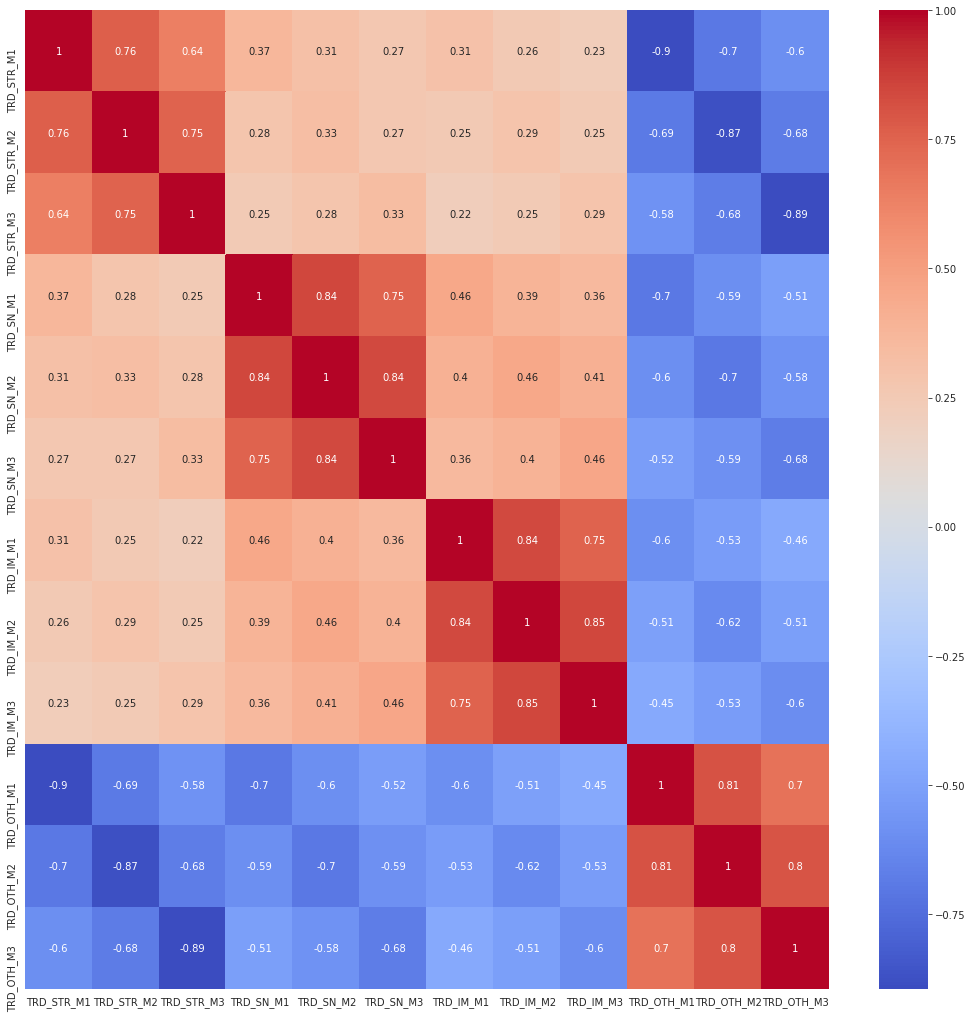

In [85]:
# FIXME: Corroborar que estas columnas tienen el total de los datos
total_data_columns = ['TRD_M1', 'TRD_M2', 'TRD_M3']
df_traffic_data_columns = [traffic_column for traffic_column in traffic_columns 
                           if traffic_column.startswith("TRD") 
                           and traffic_column not in  total_data_columns]
df_traffic_data_corr  = df_traffic[df_traffic_data_columns].corr()
# df_traffic_data_corr
plt.figure(figsize=(18, 18))
sns.heatmap(df_traffic_data_corr, annot=True, cmap='coolwarm')

Función que devuelve dos últimos elementos de iterable, en este caso mes de las columnas

In [86]:
get_month = lambda x: x[-2:]

**Tráfico de datos agrupados por mes**

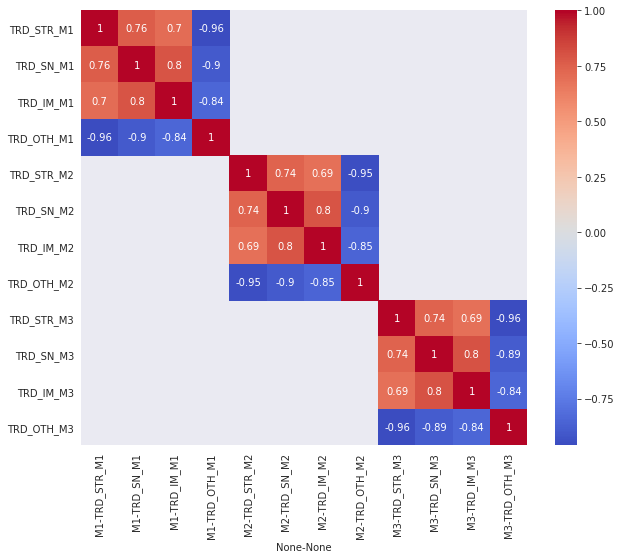

In [88]:
by_month_traffic_data_corr = df_traffic_data_corr.groupby(by=get_month, axis=1).corr()
# by_month_traffic_data_corr
plt.figure(figsize=(10, 8))
sns.heatmap(by_month_traffic_data_corr, annot=True, cmap='coolwarm')

Las variables de consumo de datos agrupadas por mes tienen una correlación bastante alta por lo que se los puede agrupar por mes.

**Número de SMS agrupados por tipo**

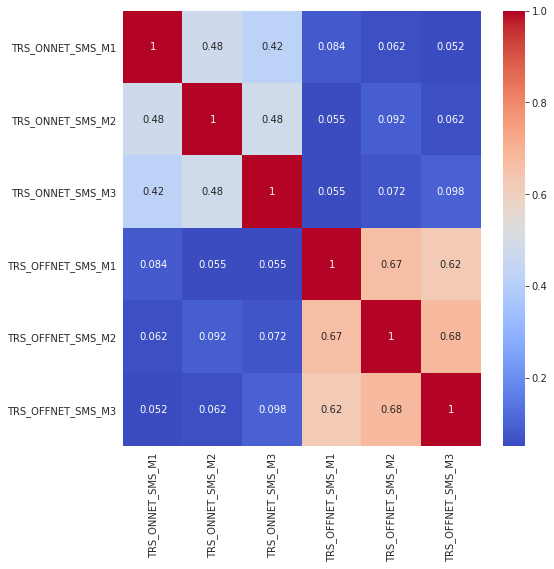

In [89]:
df_n_sms_columns = [traffic_column for traffic_column in traffic_columns if traffic_column.startswith("TRS")]
df_n_sms_corr  = df_traffic[df_n_sms_columns].corr()
# df_n_sms_corr
plt.figure(figsize=(8, 8))
sns.heatmap(df_n_sms_corr, annot=True, cmap='coolwarm')

### Número de SMS agrupados por mes

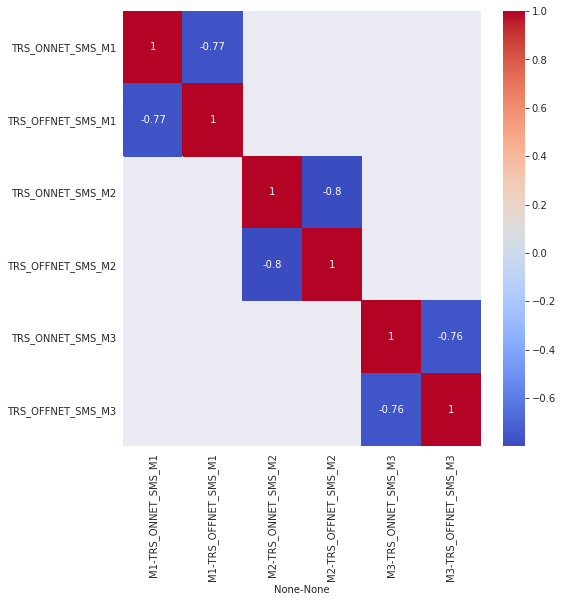

In [90]:
by_month_n_sms_corr = df_n_sms_corr.groupby(by=get_month, axis=1).corr()
# by_month_n_sms_corr
plt.figure(figsize=(8, 8))
sns.heatmap(by_month_n_sms_corr, annot=True, cmap='coolwarm')

In [86]:
df_traffic[df_n_sms_columns].describe()

,TRS_ONNET_SMS_M1,TRS_ONNET_SMS_M2,TRS_ONNET_SMS_M3,TRS_OFFNET_SMS_M1,TRS_OFFNET_SMS_M2,TRS_OFFNET_SMS_M3
count,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000
mean,0.173415,0.185037,0.191791,1.216655,1.198780,1.216179
std,0.949936,0.983975,1.002220,2.403954,2.400983,2.459793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,26.000000,36.000000,36.000000,37.000000,38.000000,30.000000


_Como los datos de SMS están acumulados en torno a cero, se descartarán estas columnas_

**Llamadas por voz agrupadas por tipo**

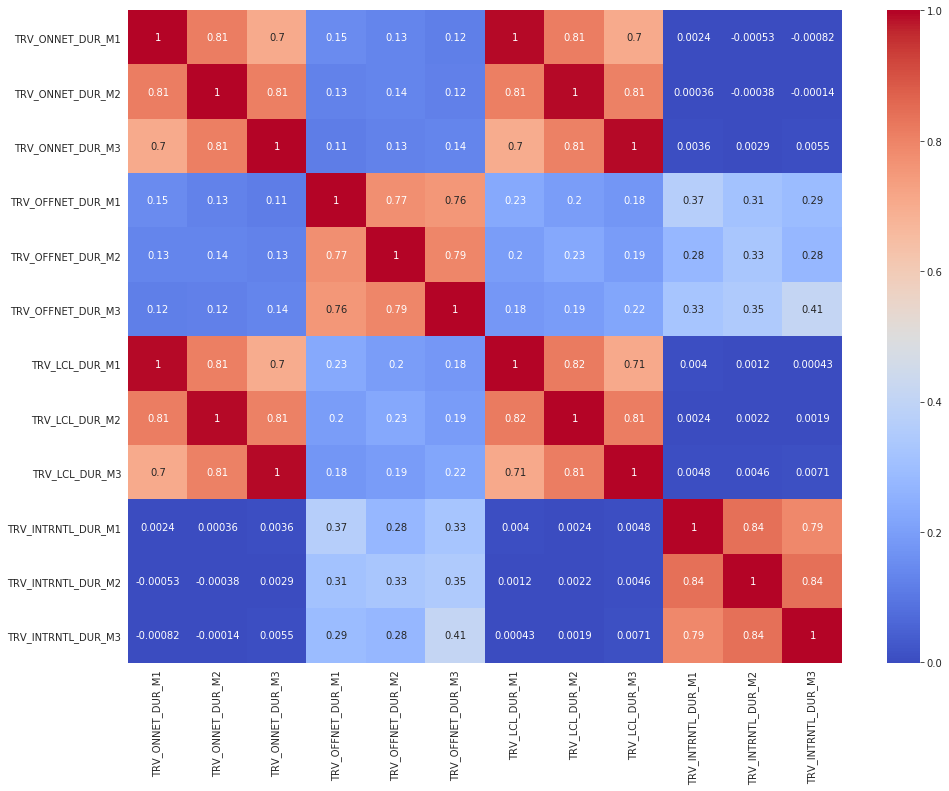

In [91]:
df_voice_minutes_columns = [traffic_column for traffic_column in traffic_columns if traffic_column.startswith("TRV")]
df_voice_minutes_corr = df_traffic[df_voice_minutes_columns].corr()
# df_n_sms_corr
plt.figure(figsize=(16, 12))
sns.heatmap(df_voice_minutes_corr, annot=True, cmap='coolwarm')

**Llamadas por voz agrupadas por mes**

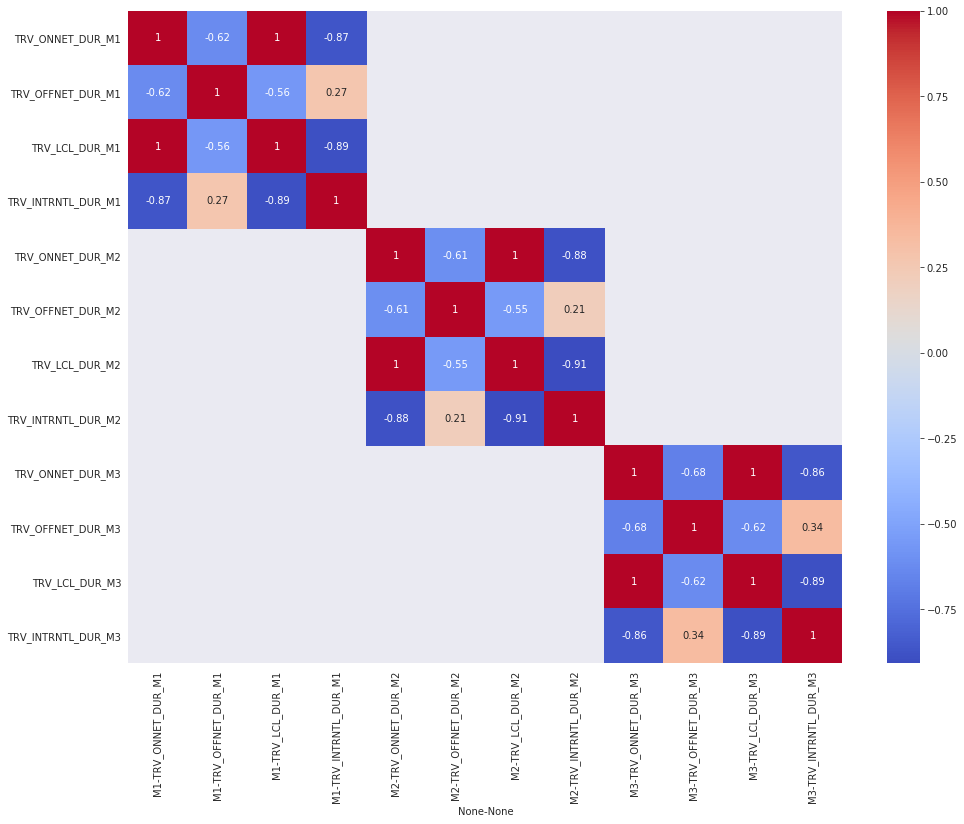

In [92]:
by_month_voice_minutes_corr = df_voice_minutes_corr.groupby(by=get_month, axis=1).corr()
# by_month_n_sms_corr
plt.figure(figsize=(16, 12))
sns.heatmap(by_month_voice_minutes_corr, annot=True, cmap='coolwarm')

### Las llamamdas tienen también una alta correlación entre sí por mes, por lo que se podrían agrupar por columnas por mes

--------------------------

# Outliers

## Tráfico de datos

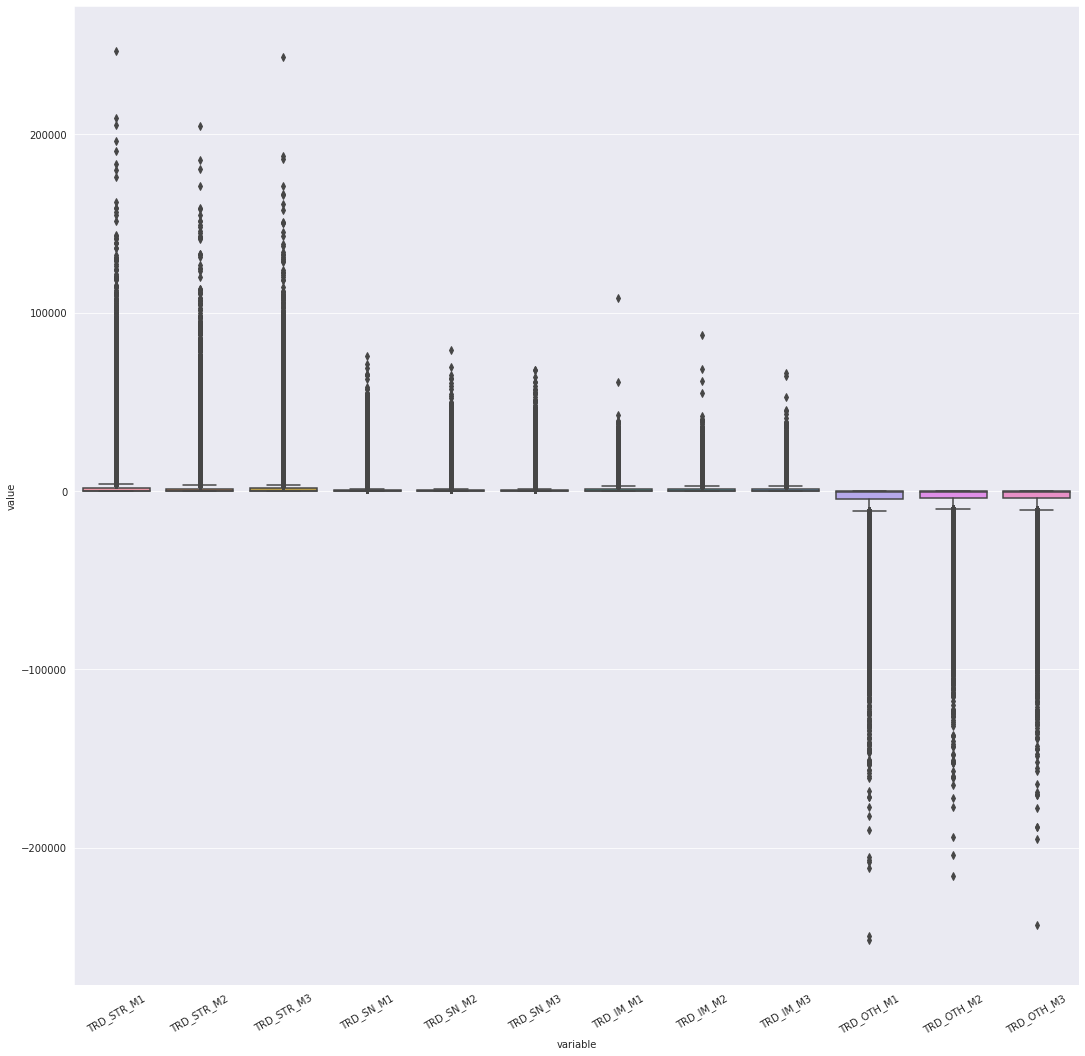

In [89]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_traffic[df_traffic_data_columns]))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

## Llamadas por voz

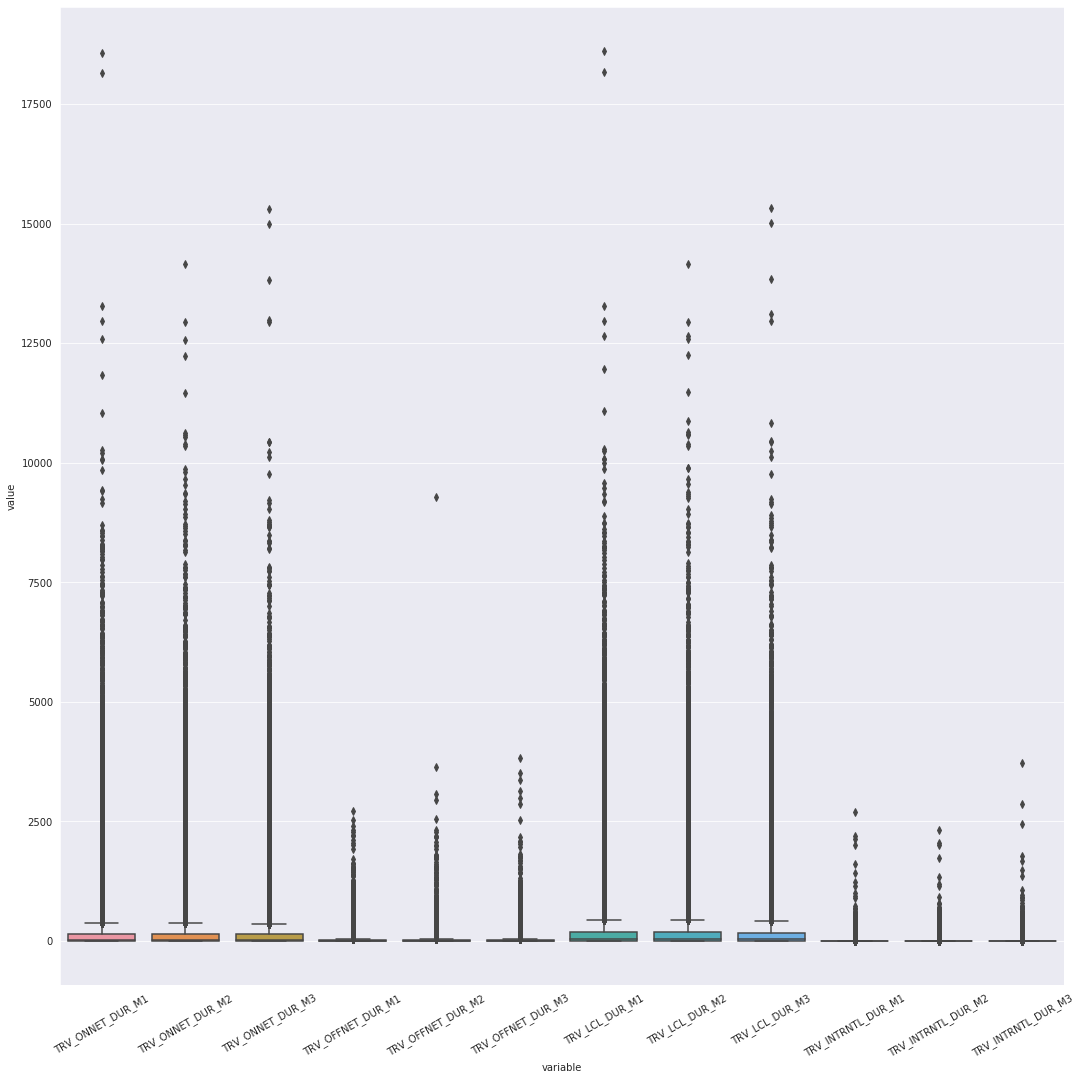

In [90]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_traffic[df_voice_minutes_columns]))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

## Sacando outliers

In [91]:
df_traffic_copy = df_traffic.copy()

In [92]:
df_traffic_data = pd.DataFrame()
for column in df_traffic[df_traffic_data_columns]:
    Q1 = df_traffic[column].quantile(0.25)
    Q3 = df_traffic[column].quantile(0.75)
    IQR = Q3 - Q1
    df_traffic_data[column] = np.where((df_traffic[column] < (Q1 - 1.5 * IQR)) | (df_traffic[column] > (Q3 + 1.5 * IQR)), df_traffic[column].median(), df_traffic[column])


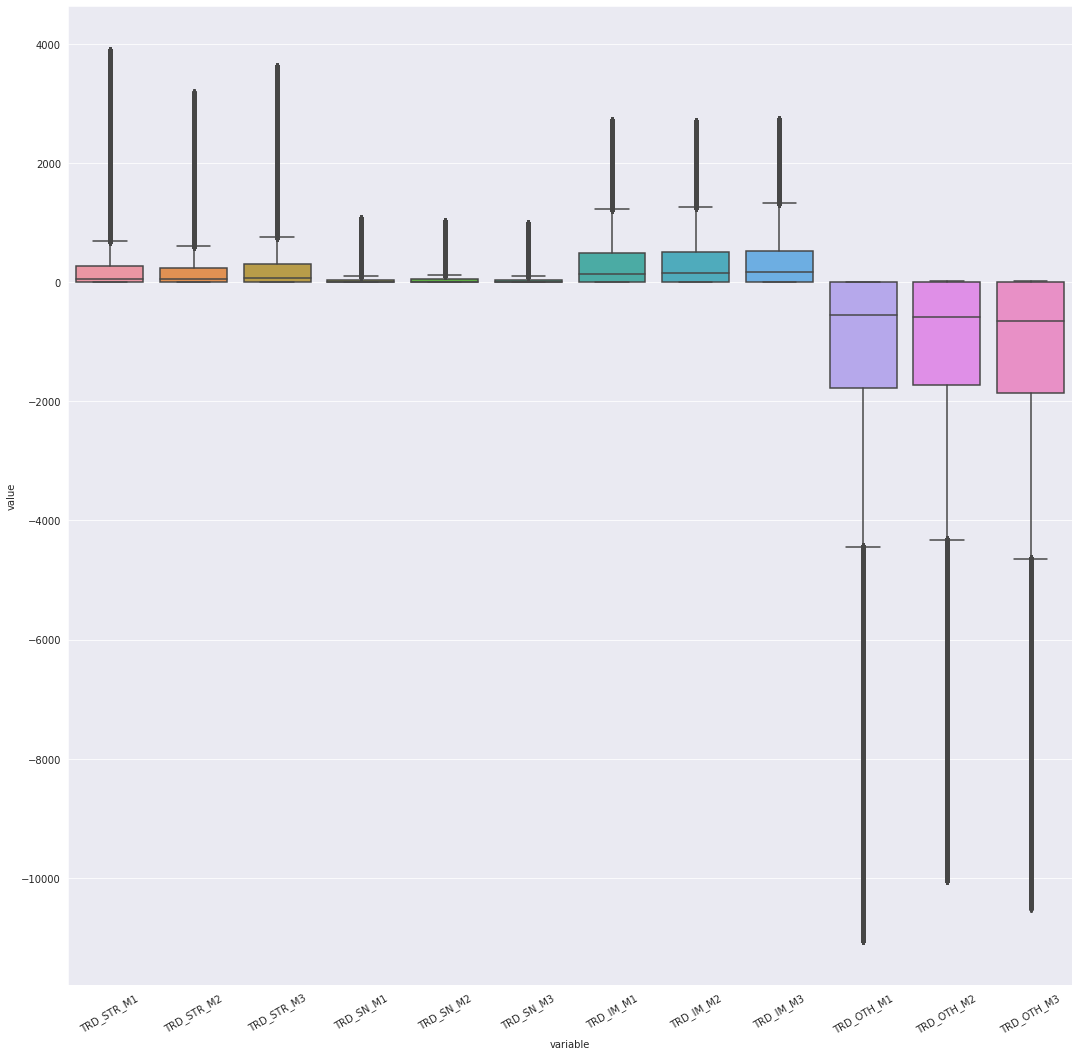

In [93]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_traffic_data))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

In [94]:
df_voice_data = pd.DataFrame()
for column in df_traffic[df_voice_minutes_columns]:
    Q1 = df_traffic[column].quantile(0.25)
    Q3 = df_traffic[column].quantile(0.75)
    IQR = Q3 - Q1
    df_voice_data[column] = np.where((df_traffic[column] < (Q1 - 1.5 * IQR)) | (df_traffic[column] > (Q3 + 1.5 * IQR)), df_traffic[column].median(), df_traffic[column])


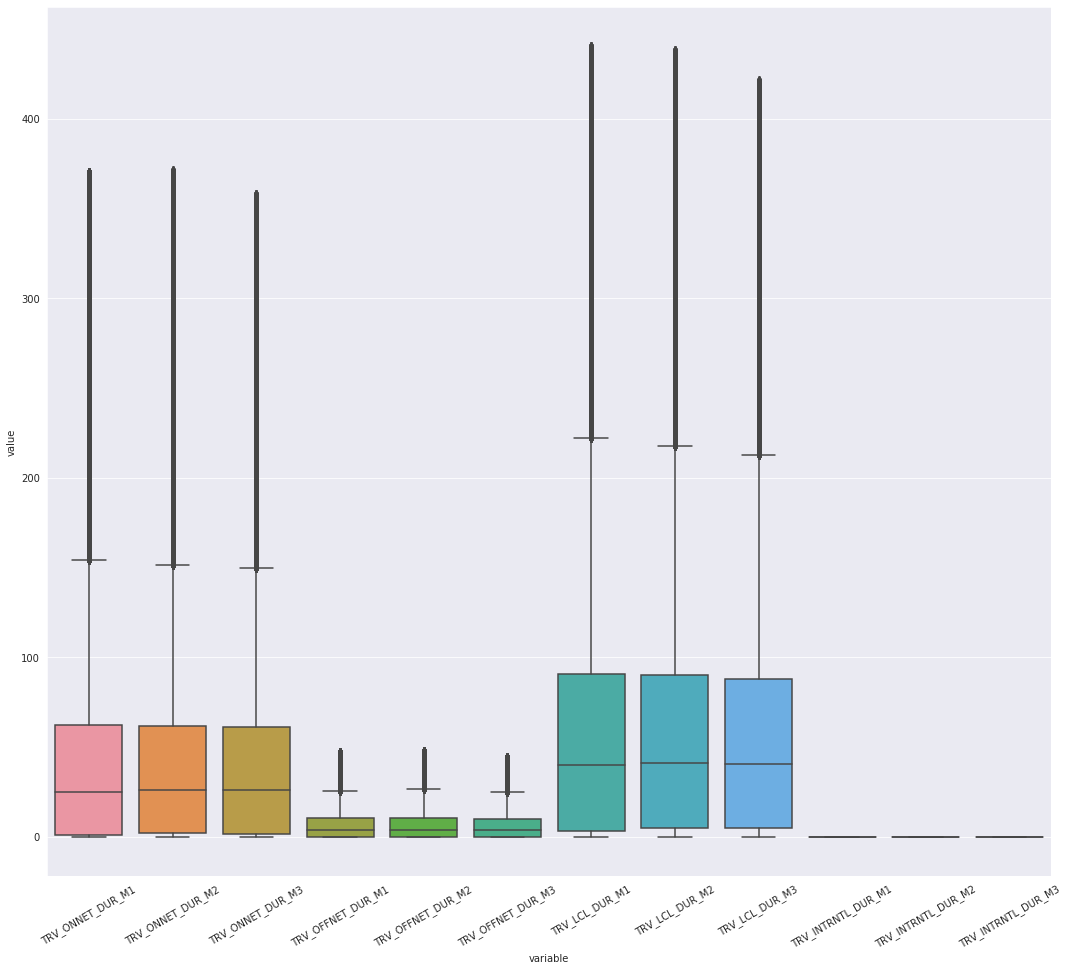

In [95]:
plt.figure(figsize=(18,16))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_voice_data))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

**Sacando datos de fulldata**

In [93]:
fulldata.drop(columns=traffic_columns, inplace=True)

In [94]:
df_traffic.drop(columns=df_n_sms_columns, inplace=True)

In [95]:
fulldata.join(other=df_traffic)

,SUSCRIBER_KEY,LAT_PROV_BTS,LON_PROV_BTS,LAT_CITY_BTS,LON_CITY_BTS,VALUE_SEGMENT,SEGMENTATION,MICROSEGMENTATION,DEVICE_MODEL_NAME,DEVICE_VENDOR_NAME,NETWORK_TECH,COMMERCIAL_ACTIVATION_DATE,TENURE_CUSTOMER,TENURE_CUSTOMER_BL,PREP_RECH_Q_EVT_X1,...,TRD_OTH_M1,TRD_OTH_M2,TRD_OTH_M3,TRV_ONNET_DUR_M1,TRV_ONNET_DUR_M2,TRV_ONNET_DUR_M3,TRV_OFFNET_DUR_M1,TRV_OFFNET_DUR_M2,TRV_OFFNET_DUR_M3,TRV_LCL_DUR_M1,TRV_LCL_DUR_M2,TRV_LCL_DUR_M3,TRV_INTRNTL_DUR_M1,TRV_INTRNTL_DUR_M2,TRV_INTRNTL_DUR_M3
0,E_63734494_20190215,8.58480,-82.38850,-82.43330,8.43330,3 - SILVER,2-PD,PD1,G4 STYLUS (H540),LG,LTE,15-FEB-19,8,8,6,...,-13044.91,-1582.94,-863.00,139.53,188.60,1.67,8.33,21.95,1.13,147.87,210.55,2.80,0.0,0.0,0.0
1,E_66977552_20190518,8.58480,-82.38850,-82.43330,8.43330,4 - BRONZE,7-LOW,LOW3,GALAXY GRAND PRIME DUOS (SM-G532M DS),SAMSUNG,LTE,18-MAY-19,5,5,0,...,0.00,0.00,0.00,0.00,0.00,0.00,2.27,4.12,0.62,2.27,4.12,0.62,0.0,0.0,0.0
2,E_69159695_20180116,8.12310,-81.07550,-78.16140,8.65525,3 - SILVER,6-OH,LOW4,GALAXY GRAND PRIME DUOS (SM-G532M DS),SAMSUNG,3G,16-JAN-18,21,21,6,...,-296.58,0.00,-64.91,1.38,0.00,0.68,8.00,3.28,0.20,9.38,3.28,0.88,0.0,0.0,0.0
3,E_65255730_20190416,9.08320,-79.59240,-79.51973,8.99360,3 - SILVER,7-LOW,LOW3,JENNY TV 2.8,BLU,LTE,16-APR-19,6,6,4,...,-119.86,0.00,0.00,1.17,0.00,0.00,0.00,0.00,0.00,1.17,0.00,0.00,0.0,0.0,0.0
4,E_67893872_20161201,9.08320,-79.59240,-79.51973,8.99360,3 - SILVER,3-DO,DO3,GALAXY J1 (SM-J111MDS),SAMSUNG,LTE,01-DEC-16,35,35,4,...,-1349.20,-2888.10,-684.12,0.00,0.00,12.05,0.00,0.08,0.00,0.00,0.08,12.05,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,E_66690182_20190121,9.41650,-82.52070,-82.52000,9.43000,4 - BRONZE,7-LOW,LOW4,GALAXY GRAND NEO (GT-I9060C),SAMSUNG,LTE,21-JAN-19,9,9,0,...,0.00,-84.47,-167.11,0.00,0.00,1.12,0.00,0.00,2.32,0.00,0.00,3.43,0.0,0.0,0.0
319218,E_65347728_20171017,9.08320,-79.59240,-79.51973,8.99360,3 - SILVER,3-DO,VD3,GALAXY J2 PRIME (SM-G532M),SAMSUNG,LTE,17-OCT-17,24,24,4,...,-1176.77,-3725.94,-3872.93,133.38,186.70,177.43,0.47,7.82,14.67,133.85,194.52,192.10,0.0,0.0,0.0
319219,E_68063707_20150701,8.79528,-80.14711,-79.65000,8.95000,3 - SILVER,6-OH,OH2,GT-E1205Q,SAMSUNG,LTE,01-JUL-15,52,52,6,...,0.00,0.00,0.00,91.50,28.77,36.33,1.00,1.07,0.42,92.50,29.83,36.75,0.0,0.0,0.0
319220,E_67206080_20181010,7.86810,-77.83670,-77.67270,8.13930,4 - BRONZE,7-LOW,VD1,Y9 2019 (JKM-LX3),HUAWEI,LTE,10-OCT-18,12,12,0,...,0.00,0.00,-3523.03,0.00,0.00,433.30,0.00,0.00,18.17,0.00,0.00,451.47,0.0,0.0,0.0


---

# Limpieza de datos de recargas

---

In [116]:
recargas_columns = [recarga_column for recarga_column in fulldata.columns if recarga_column.startswith("PREP")]
Recargas = fulldata[recargas_columns].copy()

In [117]:
Cant_rec_mes1= Recargas[['PREP_RECH_Q_EVT_W1','PREP_RECH_Q_EVT_W2','PREP_RECH_Q_EVT_W3','PREP_RECH_Q_EVT_W4'
                        ]].sum(axis=1)
Cant_rec_mes2= Recargas[['PREP_RECH_Q_EVT_W5','PREP_RECH_Q_EVT_W6','PREP_RECH_Q_EVT_W7','PREP_RECH_Q_EVT_W8'
                        ]].sum(axis=1)
Cant_rec_mes3= Recargas[['PREP_RECH_Q_EVT_W9','PREP_RECH_Q_EVT_W10','PREP_RECH_Q_EVT_W11','PREP_RECH_Q_EVT_W12'
                        ]].sum(axis=1)

In [118]:
(Cant_rec_mes1 == Recargas['PREP_RECH_Q_EVT_X1']).value_counts()

False    191491
True     127731
dtype: int64

In [119]:
(Cant_rec_mes2 == Recargas['PREP_RECH_Q_EVT_X2']).value_counts()

False    192949
True     126273
dtype: int64

In [120]:
(Cant_rec_mes3 == Recargas['PREP_RECH_Q_EVT_X3']).value_counts()

False    201542
True     117680
dtype: int64

Consideramos que la cantidad de datos que no coinciden es apreciable, entonces decidimos sacar los datos

In [121]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PREP_RECH_Q_EVT_X' in x],inplace=True)
fulldata.drop(columns=[x for x in fulldata.columns if 'PREP_RECH_Q_EVT_W' in x],inplace=True)

**Vamos a comparar los montos de recargas acumuladas, con los montos de recargas acumuladas mensuales**

In [122]:
Mont_rec_mes1= Recargas[['PREP_RECH_AMT_W1','PREP_RECH_AMT_W2','PREP_RECH_AMT_W3','PREP_RECH_AMT_W4'
                        ]].sum(axis=1)

In [123]:
Mont_rec_mes2= Recargas[['PREP_RECH_AMT_W5','PREP_RECH_AMT_W6','PREP_RECH_AMT_W7','PREP_RECH_AMT_W8'
                        ]].sum(axis=1)

In [124]:
Mont_rec_mes3= Recargas[['PREP_RECH_AMT_W9','PREP_RECH_AMT_W10','PREP_RECH_AMT_W11','PREP_RECH_AMT_W12'
                        ]].sum(axis=1)

In [125]:
(Mont_rec_mes1 == Recargas['PREP_RECH_AMT_X1']).value_counts()

True     319070
False       152
dtype: int64

In [126]:
(Mont_rec_mes2 == Recargas['PREP_RECH_AMT_X2']).value_counts()

True     319061
False       161
dtype: int64

In [127]:
(Mont_rec_mes3 == Recargas['PREP_RECH_AMT_X3']).value_counts()

True     319059
False       163
dtype: int64

Como los valores difieren en una cantidad indistinguible(menos del 1%) podemos conciderar que presentan la misma información. Por tal motivo se decide sacar las columnas de montos acumulados

In [128]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PREP_RECH_AMT_X' in x],inplace=True)

In [129]:
fulldata.shape

(319222, 85)

**Seguimos trabajando con las recargas**

Eliminamos en el dataframe de recargas, las mismas columnas que eliminamos en el fulldata

In [130]:
def Borrar_columnas(df, grupo_de_columnas):
    df.drop(columns=[x for x in Recargas.columns if grupo_de_columnas in x],inplace=True)

In [135]:
Borrar_columnas(Recargas,'PREP_RECH_AMT_X')
Borrar_columnas(Recargas,'PREP_RECH_Q_EVT_W')
Borrar_columnas(Recargas,'PREP_RECH_Q_EVT_X')

In [136]:
Recargas.shape

(319222, 22)

### Análisis de correlación

*Correlación entre Cantidad de recargas en x día durante las 12 semanas*

In [138]:
Cant_rec_en_dias= Recargas[[x for x in Recargas.columns if 'PREP_RECH_Q' in x]]
Cant_rec_en_dias.describe()

,PREP_RECH_Q_MON_12W,PREP_RECH_Q_TUE_12W,PREP_RECH_Q_WEN_12W,PREP_RECH_Q_THUR_12W,PREP_RECH_Q_FRI_12W,PREP_RECH_Q_SAT_12W,PREP_RECH_Q_SUN_12W
count,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000
mean,2.770473,2.484537,2.536645,2.655685,2.839980,2.566596,2.336622
std,2.633008,2.520506,2.517774,2.534744,2.589916,2.572251,2.470489
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,39.000000,43.000000,38.000000,37.000000,38.000000,51.000000,38.000000


In [139]:
Cant_rec_en_dias.corr()

,PREP_RECH_Q_MON_12W,PREP_RECH_Q_TUE_12W,PREP_RECH_Q_WEN_12W,PREP_RECH_Q_THUR_12W,PREP_RECH_Q_FRI_12W,PREP_RECH_Q_SAT_12W,PREP_RECH_Q_SUN_12W
PREP_RECH_Q_MON_12W,1.000000,0.379673,0.354563,0.382599,0.351402,0.284211,0.304759
PREP_RECH_Q_TUE_12W,0.379673,1.000000,0.383747,0.352447,0.359342,0.335362,0.277231
PREP_RECH_Q_WEN_12W,0.354563,0.383747,1.000000,0.381315,0.346658,0.328482,0.326740
PREP_RECH_Q_THUR_12W,0.382599,0.352447,0.381315,1.000000,0.381090,0.289958,0.315796
PREP_RECH_Q_FRI_12W,0.351402,0.359342,0.346658,0.381090,1.000000,0.320213,0.283657
PREP_RECH_Q_SAT_12W,0.284211,0.335362,0.328482,0.289958,0.320213,1.000000,0.327095
PREP_RECH_Q_SUN_12W,0.304759,0.277231,0.326740,0.315796,0.283657,0.327095,1.000000


Vemos que los coeficientes de Pearson entre las variables expresan que no hay correlación entre las variables analizadas

### Correlación entre montos acumulados de recargas por semana

In [140]:
Mont_Acum_por_sem= Recargas[[x for x in Recargas.columns if 'PREP_RECH_AMT_W' in x]]
Mont_Acum_por_sem.describe()

,PREP_RECH_AMT_W1,PREP_RECH_AMT_W2,PREP_RECH_AMT_W3,PREP_RECH_AMT_W4,PREP_RECH_AMT_W5,PREP_RECH_AMT_W6,PREP_RECH_AMT_W7,PREP_RECH_AMT_W8,PREP_RECH_AMT_W9,PREP_RECH_AMT_W10,PREP_RECH_AMT_W11,PREP_RECH_AMT_W12
count,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000
mean,2.732087,3.217064,2.817290,3.549195,2.998092,3.173191,2.840202,3.345359,3.122188,3.111067,3.377898,3.160723
std,3.857857,4.218097,3.879877,4.514366,4.087966,4.171063,3.952560,4.252033,4.167941,4.133527,4.239955,4.122492
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,3.000000,1.500000,2.000000,0.000000,3.000000,2.000000,2.000000,3.000000,3.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,85.000000,345.000000,133.000000,170.000000,98.000000,168.220000,125.000000,123.690000,150.000000,120.000000,210.000000,115.000000


In [141]:
Mont_Acum_por_sem.corr()

,PREP_RECH_AMT_W1,PREP_RECH_AMT_W2,PREP_RECH_AMT_W3,PREP_RECH_AMT_W4,PREP_RECH_AMT_W5,PREP_RECH_AMT_W6,PREP_RECH_AMT_W7,PREP_RECH_AMT_W8,PREP_RECH_AMT_W9,PREP_RECH_AMT_W10,PREP_RECH_AMT_W11,PREP_RECH_AMT_W12
PREP_RECH_AMT_W1,1.000000,0.387587,0.450786,0.404695,0.449589,0.418191,0.389979,0.362100,0.379022,0.389557,0.352022,0.336874
PREP_RECH_AMT_W2,0.387587,1.000000,0.416184,0.460712,0.431145,0.462956,0.418715,0.406668,0.385504,0.374179,0.413962,0.332321
PREP_RECH_AMT_W3,0.450786,0.416184,1.000000,0.398843,0.461153,0.423277,0.450026,0.412411,0.397969,0.383072,0.376044,0.384792
PREP_RECH_AMT_W4,0.404695,0.460712,0.398843,1.000000,0.428096,0.456106,0.411002,0.473736,0.432682,0.384098,0.394640,0.356400
PREP_RECH_AMT_W5,0.449589,0.431145,0.461153,0.428096,1.000000,0.426950,0.454438,0.419277,0.459938,0.432653,0.397538,0.377575
PREP_RECH_AMT_W6,0.418191,0.462956,0.423277,0.456106,0.426950,1.000000,0.416285,0.435692,0.432031,0.443515,0.436375,0.376568
PREP_RECH_AMT_W7,0.389979,0.418715,0.450026,0.411002,0.454438,0.416285,1.000000,0.390575,0.450066,0.419207,0.440426,0.408003
PREP_RECH_AMT_W8,0.362100,0.406668,0.412411,0.473736,0.419277,0.435692,0.390575,1.000000,0.406533,0.431688,0.407624,0.415469
PREP_RECH_AMT_W9,0.379022,0.385504,0.397969,0.432682,0.459938,0.432031,0.450066,0.406533,1.000000,0.426734,0.446665,0.414405
PREP_RECH_AMT_W10,0.389557,0.374179,0.383072,0.384098,0.432653,0.443515,0.419207,0.431688,0.426734,1.000000,0.402197,0.437371


Los coeficientes de Pearson entre las variables expresan que no hay correlación entre ellas.

## Outliers

**Cantidad de recargas en x dias durante las 12 semanas**

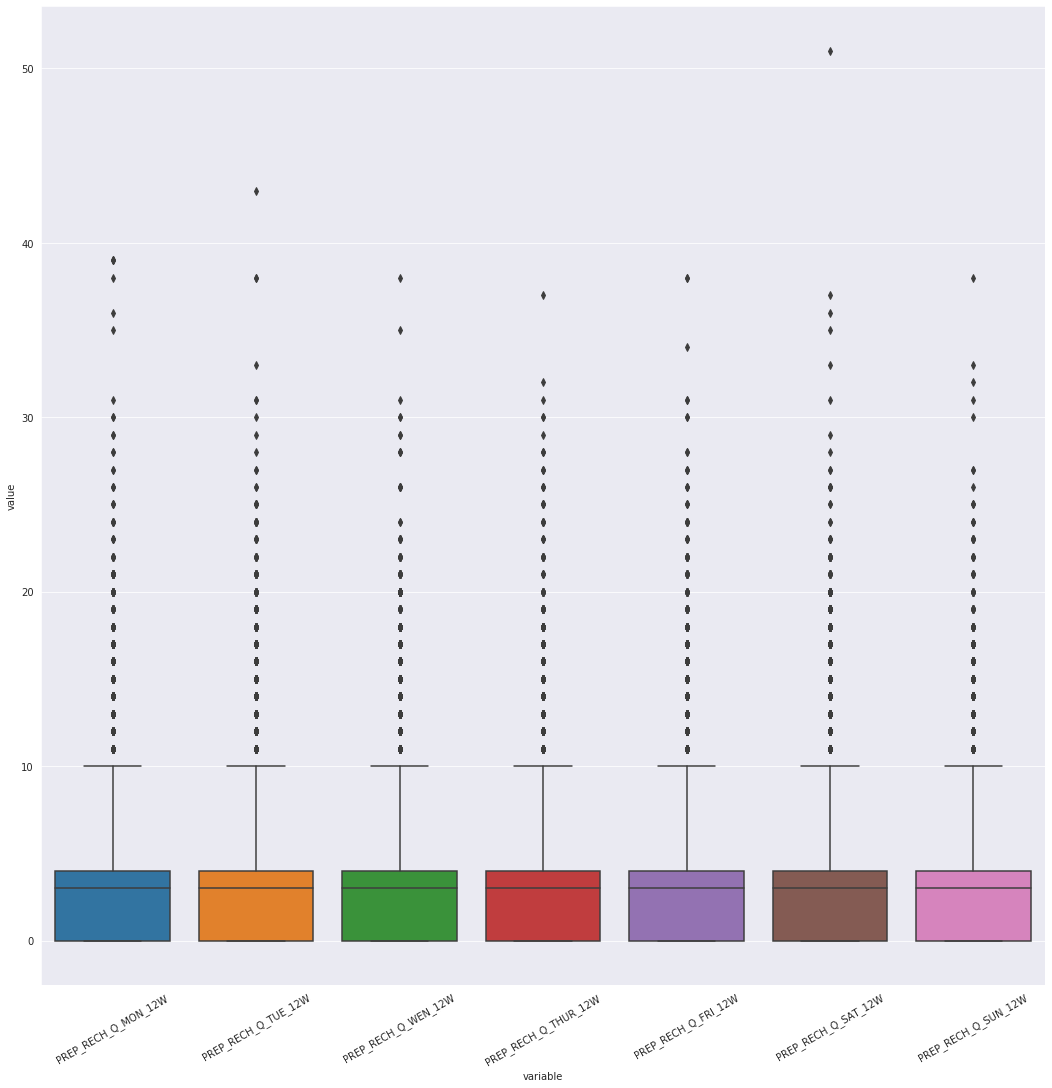

In [142]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(Cant_rec_en_dias))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

In [143]:
Cant_rec_en_dias.describe()

,PREP_RECH_Q_MON_12W,PREP_RECH_Q_TUE_12W,PREP_RECH_Q_WEN_12W,PREP_RECH_Q_THUR_12W,PREP_RECH_Q_FRI_12W,PREP_RECH_Q_SAT_12W,PREP_RECH_Q_SUN_12W
count,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000
mean,2.770473,2.484537,2.536645,2.655685,2.839980,2.566596,2.336622
std,2.633008,2.520506,2.517774,2.534744,2.589916,2.572251,2.470489
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,39.000000,43.000000,38.000000,37.000000,38.000000,51.000000,38.000000


Vemos que en todas las columnas el rango intercuartil es 4. Así que vamos a ver cuantas mediciones superan en dos veces el rango (y lo dividimos por el total de filas para obtener una frecuencia relativa). 

In [144]:
print(((Recargas['PREP_RECH_Q_MON_12W']>12).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_TUE_12W']>12).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_WEN_12W']>12).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_THUR_12W']>12).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_FRI_12W']>12).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_SAT_12W']>12).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_SUN_12W']>12).value_counts())/ len(Recargas.index)
     )

False    0.996319
True     0.003681
Name: PREP_RECH_Q_MON_12W, dtype: float64 False    0.997597
True     0.002403
Name: PREP_RECH_Q_TUE_12W, dtype: float64 False    0.997331
True     0.002669
Name: PREP_RECH_Q_WEN_12W, dtype: float64 False    0.997387
True     0.002613
Name: PREP_RECH_Q_THUR_12W, dtype: float64 False    0.996955
True     0.003045
Name: PREP_RECH_Q_FRI_12W, dtype: float64 False    0.996877
True     0.003123
Name: PREP_RECH_Q_SAT_12W, dtype: float64 False    0.997679
True     0.002321
Name: PREP_RECH_Q_SUN_12W, dtype: float64


Además veamos el coeficiente de variación.

In [132]:
(Recargas['PREP_RECH_Q_MON_12W'].std()/Recargas['PREP_RECH_Q_MON_12W'].mean())*100

95.03818759314608

**Se calcula uno sólo, pero al ver la tabla del "describe" se puede notar que los demás coeficientes también son superiores al 90%. Por lo tanto, se igualará a todos los valores superiores a dos veces el rango, por el valor de 4+2*R, con el objetivo de influir lo menos posible en la distribución, y que los valores atípicos no influyan de manera apreciable en la media y desvío estándar.**

In [145]:
### Función que nos modifica los outliers por el número o variable que le ingresemos en y

def Sacar_outliers(x,y):
    x=np.where(x>y, x==y, x)
  

In [146]:
fulldata[['PREP_RECH_Q_MON_12W']]= Sacar_outliers(fulldata[['PREP_RECH_Q_MON_12W']],12)
fulldata[['PREP_RECH_Q_TUE_12W']]= Sacar_outliers(fulldata[['PREP_RECH_Q_TUE_12W']],12)
fulldata[['PREP_RECH_Q_WEN_12W']]= Sacar_outliers(fulldata[['PREP_RECH_Q_WEN_12W']],12)
fulldata[['PREP_RECH_Q_THUR_12W']]= Sacar_outliers(fulldata[['PREP_RECH_Q_THUR_12W']],12)
fulldata[['PREP_RECH_Q_FRI_12W']]= Sacar_outliers(fulldata[['PREP_RECH_Q_FRI_12W']],12)
fulldata[['PREP_RECH_Q_SAT_12W']]= Sacar_outliers(fulldata[['PREP_RECH_Q_SAT_12W']],12)
fulldata[['PREP_RECH_Q_SUN_12W']]= Sacar_outliers(fulldata[['PREP_RECH_Q_SUN_12W']],12)

In [147]:
((fulldata['PREP_RECH_Q_SAT_12W']>12).value_counts())/ len(fulldata.index)

False    1.0
Name: PREP_RECH_Q_SAT_12W, dtype: float64

### Monto acumulado de recargas por semana


In [148]:
type(Recargas[[x for x in Recargas.columns if 'PREP_RECH_AMT_W' in x]])

pandas.core.frame.DataFrame

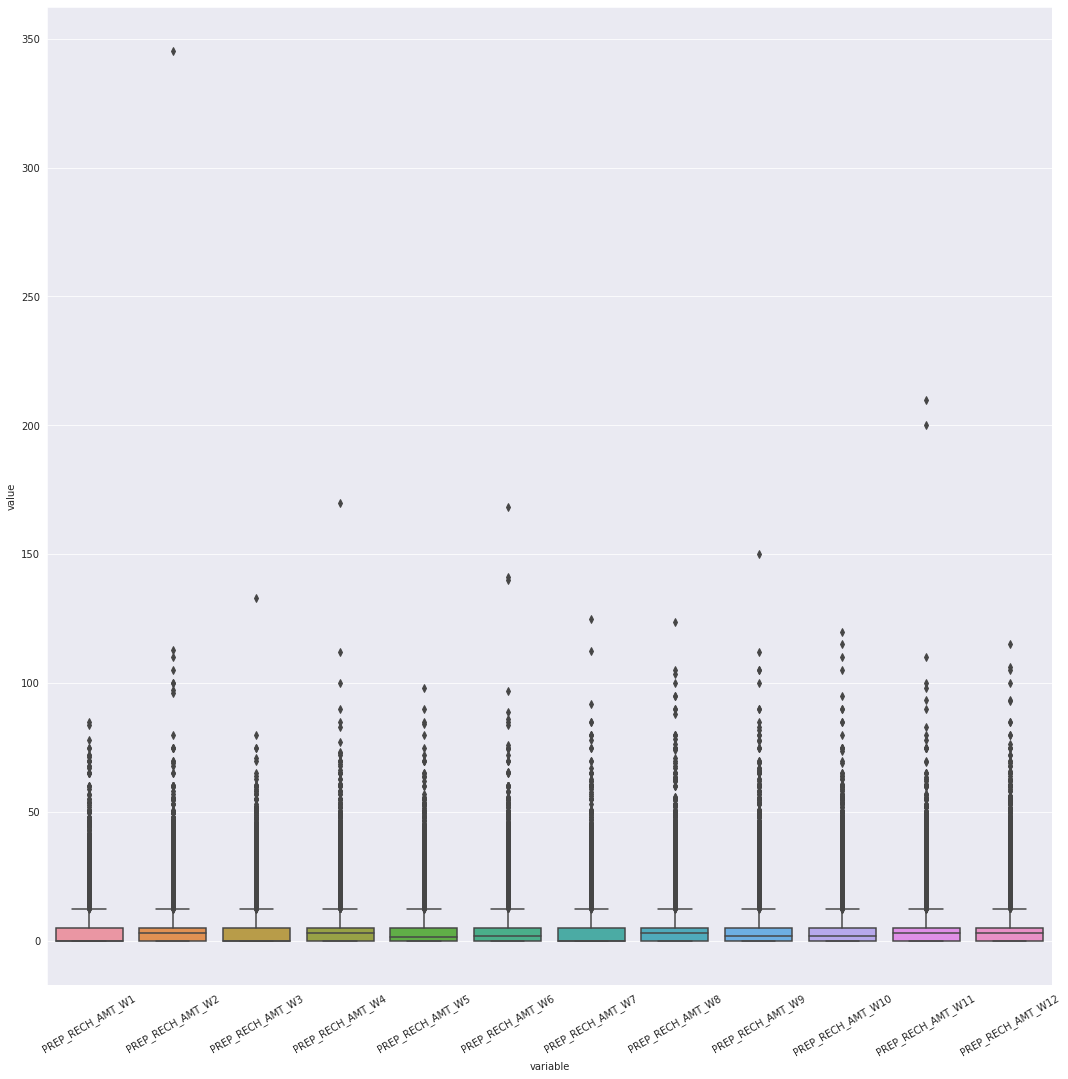

In [149]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(Mont_Acum_por_sem))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

In [150]:
Mont_Acum_por_sem.describe()

,PREP_RECH_AMT_W1,PREP_RECH_AMT_W2,PREP_RECH_AMT_W3,PREP_RECH_AMT_W4,PREP_RECH_AMT_W5,PREP_RECH_AMT_W6,PREP_RECH_AMT_W7,PREP_RECH_AMT_W8,PREP_RECH_AMT_W9,PREP_RECH_AMT_W10,PREP_RECH_AMT_W11,PREP_RECH_AMT_W12
count,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000
mean,2.732087,3.217064,2.817290,3.549195,2.998092,3.173191,2.840202,3.345359,3.122188,3.111067,3.377898,3.160723
std,3.857857,4.218097,3.879877,4.514366,4.087966,4.171063,3.952560,4.252033,4.167941,4.133527,4.239955,4.122492
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,3.000000,1.500000,2.000000,0.000000,3.000000,2.000000,2.000000,3.000000,3.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,85.000000,345.000000,133.000000,170.000000,98.000000,168.220000,125.000000,123.690000,150.000000,120.000000,210.000000,115.000000


Vemos que en todas las columnas el rango intercuartil es 5(Q3-Q1). Así que vamos a ver cuantas mediciones superan en tres veces el rango (más el tercer cuartil), y lo dividimos por el total de filas para obtener una frecuencia relativa. 

In [151]:
print(((Recargas['PREP_RECH_AMT_W1']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W2']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W3']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W4']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W5']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W6']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W7']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W8']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W9']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W10']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W11']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W12']>20).value_counts())/ len(Recargas.index)
     )

False    0.996435
True     0.003565
Name: PREP_RECH_AMT_W1, dtype: float64 False    0.995423
True     0.004577
Name: PREP_RECH_AMT_W2, dtype: float64 False    0.996219
True     0.003781
Name: PREP_RECH_AMT_W3, dtype: float64 False    0.994061
True     0.005939
Name: PREP_RECH_AMT_W4, dtype: float64 False    0.995442
True     0.004558
Name: PREP_RECH_AMT_W5, dtype: float64 False    0.995282
True     0.004718
Name: PREP_RECH_AMT_W6, dtype: float64 False    0.995946
True     0.004054
Name: PREP_RECH_AMT_W7, dtype: float64 False    0.9948
True     0.0052
Name: PREP_RECH_AMT_W8, dtype: float64 False    0.995003
True     0.004997
Name: PREP_RECH_AMT_W9, dtype: float64 False    0.995104
True     0.004896
Name: PREP_RECH_AMT_W10, dtype: float64 False    0.994856
True     0.005144
Name: PREP_RECH_AMT_W11, dtype: float64 False    0.995191
True     0.004809
Name: PREP_RECH_AMT_W12, dtype: float64


Además veamos el coeficiente de variación.

In [152]:
(Recargas['PREP_RECH_AMT_W1'].std()/Recargas['PREP_RECH_AMT_W1'].mean())*100

141.2055207208845

In [153]:
### Se calcula uno sólo, pero al ver la tabla del "describe" se puede notar que los demás coeficientes son muy altos, debido a que el desvío estándar es superior a la media. Por lo tanto, se igualará a todos los valores superiores a tres veces el rango, por el valor de 5+3*R, con el objetivo de influir lo menos posible en la distribución, y que los valores atípicos no influyan de manera apreciable en la media y desvío estándar.

In [154]:
fulldata[['PREP_RECH_AMT_W1']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W1']],20)
fulldata[['PREP_RECH_AMT_W2']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W2']],20)
fulldata[['PREP_RECH_AMT_W3']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W3']],20)
fulldata[['PREP_RECH_AMT_W4']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W4']],20)
fulldata[['PREP_RECH_AMT_W5']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W5']],20)
fulldata[['PREP_RECH_AMT_W6']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W6']],20)
fulldata[['PREP_RECH_AMT_W7']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W7']],20)
fulldata[['PREP_RECH_AMT_W8']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W8']],20)
fulldata[['PREP_RECH_AMT_W9']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W9']],20)
fulldata[['PREP_RECH_AMT_W10']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W10']],20)
fulldata[['PREP_RECH_AMT_W11']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W11']],20)
fulldata[['PREP_RECH_AMT_W12']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W12']],20)

In [155]:
((fulldata['PREP_RECH_AMT_W12']>20).value_counts())/ len(fulldata.index)

False    1.0
Name: PREP_RECH_AMT_W12, dtype: float64

In [156]:
### Días desde la última recarga

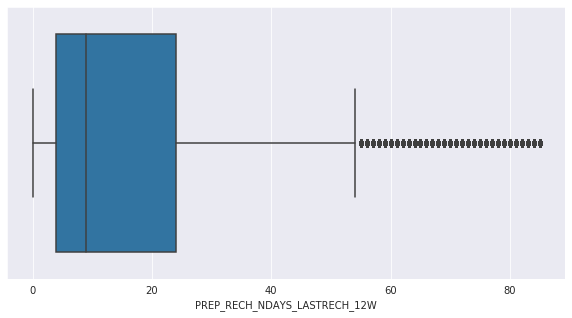

In [161]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x=Recargas['PREP_RECH_NDAYS_LASTRECH_12W'])

In [162]:
Recargas['PREP_RECH_NDAYS_LASTRECH_12W'].describe()

count    319222.000000
mean         17.858826
std          20.374863
min           0.000000
25%           4.000000
50%           9.000000
75%          24.000000
max          85.000000
Name: PREP_RECH_NDAYS_LASTRECH_12W, dtype: float64

**Se decide no modificar la columna, debido a que el valor máximo que asume la varible es 85, está muy cerca de 3*R+Q3**

---

# Tratamiento de filas según fecha de alta

 ---

Se trabajará la columna de fechas de alta del fulldata

In [163]:
## Se hará que python interprete a la columna de activación comercial como fecha
fulldata['Date'] = pd.to_datetime(fulldata['COMMERCIAL_ACTIVATION_DATE'], format='%d-%b-%y') 
fulldata['Dayofweek'] = fulldata['Date'].dt.dayofweek 
fulldata['Month'] = fulldata['Date'].dt.month 
fulldata['Year'] = fulldata['Date'].dt.year 
fulldata['Period'] = fulldata['Date'].dt.to_period('M') 
fulldata.sort_values('Date', inplace=True) 

In [164]:
fulldata[['COMMERCIAL_ACTIVATION_DATE', 'Date', 'Dayofweek', 'Month', 'Year', 'Period']]

,COMMERCIAL_ACTIVATION_DATE,Date,Dayofweek,Month,Year,Period
171412,10-JUL-11,2011-07-10,6,7,2011,2011-07
287516,10-JUL-11,2011-07-10,6,7,2011,2011-07
180405,25-NOV-11,2011-11-25,4,11,2011,2011-11
298876,25-NOV-11,2011-11-25,4,11,2011,2011-11
255393,22-APR-12,2012-04-22,6,4,2012,2012-04
...,...,...,...,...,...,...
293654,17-JUN-19,2019-06-17,0,6,2019,2019-06
81203,17-JUN-19,2019-06-17,0,6,2019,2019-06
56837,17-JUN-19,2019-06-17,0,6,2019,2019-06
153673,17-JUN-19,2019-06-17,0,6,2019,2019-06


Ahora usaremos una tabla pivot para calcular la cantidad de activaciones que por mes en cada año

In [166]:
pd.pivot_table(data=fulldata, index=['Year'], columns=['Month'], aggfunc=['size'])

size                                                               \
Month      1       2        3        4        5        6        7       8    
Year                                                                         
2011      NaN     NaN      NaN      NaN      NaN      NaN      2.0     NaN   
2012      NaN     NaN      NaN      5.0      3.0      NaN      NaN     NaN   
2013      NaN     NaN      NaN      NaN      2.0      NaN     24.0     NaN   
2014      NaN     NaN      NaN      NaN      NaN      NaN      NaN     NaN   
2015     14.0     NaN     14.0      NaN   2322.0  34682.0  55817.0  3208.0   
2016   2284.0  2160.0   2231.0   2261.0   6674.0   3943.0   2310.0  2569.0   
2017   3481.0  3245.0   3591.0   2967.0   3178.0   3743.0   3231.0  3511.0   
2018   4730.0  3945.0   5102.0   4927.0   4517.0   5194.0   5848.0  6149.0   
2019   9615.0  9536.0  11358.0  11440.0  13163.0   8855.0      NaN     NaN   

                                        
Month      9       10      11       12  
Year                                    
2011      NaN     NaN     2.0      NaN  
2012      7.0     NaN     NaN      NaN  
2013      NaN     NaN     NaN      NaN  
2014      NaN     NaN    49.0     73.0  
2015   1926.0  2068.0  1968.0   2829.0  
2016   2621.0  2846.0  2626.0   4515.0  
2017   3273.0  3790.0  3426.0   5582.0  
2018   5959.0  6395.0  6614.0  10802.0  
2019      NaN     NaN     NaN      NaN

**Sacaremos todas las filas de los periodos anteriores al periodo en el cual se dan de alta líneas de manera consecutiva**

In [167]:
period = pd.to_datetime('2015-05').to_period('M')
fulldata = fulldata[fulldata['Period']>=period]

In [168]:
pivot_table = pd.pivot_table(data=fulldata, index=['Year'], columns=['Month'], aggfunc=['size'], fill_value=0)
pivot_table

size                                                                   \
Month    1     2      3      4      5      6      7     8     9     10    11   
Year                                                                           
2015      0     0      0      0   2322  34682  55817  3208  1926  2068  1968   
2016   2284  2160   2231   2261   6674   3943   2310  2569  2621  2846  2626   
2017   3481  3245   3591   2967   3178   3743   3231  3511  3273  3790  3426   
2018   4730  3945   5102   4927   4517   5194   5848  6149  5959  6395  6614   
2019   9615  9536  11358  11440  13163   8855      0     0     0     0     0   

              
Month     12  
Year          
2015    2829  
2016    4515  
2017    5582  
2018   10802  
2019       0

In [170]:
total_rows = fulldata.shape[0]
total_rows

319027

Ahora veamos que pasa en términos de frecuencias relativas en la tabla pivot

In [171]:
pivot_table.divide(total_rows) * 100

size                                                                \
Month        1         2         3         4         5          6          7    
Year                                                                            
2015   0.000000  0.000000  0.000000  0.000000  0.727838  10.871180  17.496011   
2016   0.715927  0.677059  0.699314  0.708717  2.091986   1.235946   0.724077   
2017   1.091130  1.017155  1.125610  0.930015  0.996154   1.173255   1.012767   
2018   1.482633  1.236572  1.599238  1.544383  1.415868   1.628075   1.833074   
2019   3.013851  2.989089  3.560200  3.585903  4.125983   2.775627   0.000000   

                                                         
Month        8         9         10        11        12  
Year                                                     
2015   1.005558  0.603711  0.648221  0.616876  0.886759  
2016   0.805261  0.821561  0.892088  0.823128  1.415241  
2017   1.100534  1.025932  1.187987  1.073890  1.749695  
2018   1.927423  1.867867  2.004533  2.073179  3.385920  
2019   0.000000  0.000000  0.000000  0.000000  0.000000

Vemos que la mayoría de las frecuencias relativas son menores que 4,2 y tenemos valores en junio y julio del 2015 muy superiores al 4,2. Por lo tanto, se decide sacar todo el periodo menor a agosto de 2015, por considerarlos datos erroneos que podrían ensuciar el modelo

In [172]:
period = pd.to_datetime('2015-08').to_period('M')
fulldata = fulldata[fulldata['Period']>=period]
print(fulldata.shape[0])

226206


---

## Encoding variables categóricas

---

In [173]:
num_cols = fulldata._get_numeric_data().columns 
cat_columns = list(set(fulldata.columns) - set(num_cols))

In [176]:
fulldata[cat_columns].nunique()

PREP_RECH_AMT_W6                   0
PREP_RECH_LAST_DAY_12W            84
SEGMENTATION                       7
PREP_RECH_AMT_W4                   0
COMMERCIAL_ACTIVATION_DATE      1417
PREP_RECH_CHNNL_MODE12W         5677
PREP_RECH_Q_SUN_12W                0
PREP_RECH_Q_THUR_12W               0
MICROSEGMENTATION                 25
PREP_RECH_AMT_W7                   0
PREP_RECH_AMT_W9                   0
PREP_RECH_AMT_W1                   0
PREP_RECH_Q_MON_12W                0
PREP_RECH_AMT_W12                  0
PREP_RECH_Q_WEN_12W                0
PREP_RECH_AMT_W5                   0
SUSCRIBER_KEY                 226206
PREP_RECH_AMT_W11                  0
Date                            1417
DEVICE_MODEL_NAME               2141
PREP_RECH_Q_FRI_12W                0
Period                            47
PREP_RECH_Q_SAT_12W                0
PREP_RECH_Q_TUE_12W                0
PREP_RECH_AMT_W8                   0
PREP_RECH_AMT_W3                   0
VALUE_SEGMENT                      4
N

**Después de inspeccionar estas variables, con imágenes de value counts, nos detenemos en el caso de DEVICE_VENDOR_NAME**

In [177]:
fulldata.DEVICE_VENDOR_NAME.value_counts(normalize=True)[0:10]

SAMSUNG       0.640447
HUAWEI        0.173939
LG            0.050578
BLU           0.032395
NOKIA         0.022347
APPLE         0.016551
UNKNOWN       0.011083
GREYMARKET    0.007873
HYUNDAI       0.006963
ALCATEL       0.005866
Name: DEVICE_VENDOR_NAME, dtype: float64

**Vemos que la mayoria se concentra en 6 marcas, remplazaremos con 'Other' para poder aplicar hot encoding**

In [179]:
n = 6
most_frequent_vendors = fulldata['DEVICE_VENDOR_NAME'].value_counts()[:n].index.tolist()
fulldata.loc[~fulldata["DEVICE_VENDOR_NAME"].isin(most_frequent_vendors), "DEVICE_VENDOR_NAME"] = "Other"

In [180]:
fulldata.DEVICE_VENDOR_NAME.value_counts(normalize=1)

SAMSUNG    0.640447
HUAWEI     0.173939
Other      0.080294
LG         0.050578
BLU        0.032395
NOKIA      0.022347
Name: DEVICE_VENDOR_NAME, dtype: float64

**Aplicaremos one hot encode a las columnas SEGMENTATION, VALUE_SEGMENT, NETWORK_TECH, DEVICE_VENDOR_NAME**

In [181]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

In [182]:
fulldata.shape

(226206, 90)

In [183]:
columns_to_encode = ['SEGMENTATION', 'VALUE_SEGMENT', 'NETWORK_TECH', 'DEVICE_VENDOR_NAME']
for column in columns_to_encode: 
    fulldata = encode_and_bind(fulldata, column)
fulldata.shape

(226206, 110)

---

# Correlación variables con target

---

In [185]:
feature_target_correlation = fulldata[fulldata.columns[1:]].corr()['Target'].dropna()
feature_target_correlation.abs().sort_values(ascending=False)[0:15]

Target                          1.000000
PREP_RECH_NDAYS_LASTRECH_12W    0.551611
SEGMENTATION_7-LOW              0.484010
VALUE_SEGMENT_4 - BRONZE        0.413995
PACK_DATA_EXP_W1                0.396922
PACK_DATA_EXP_W2                0.396833
PACK_DATA_AMT_W2                0.372390
PACK_DATA_EXP_W3                0.371835
PACK_DATA_AMT_W1                0.363064
PACK_DATA_EXP_W4                0.345029
PACK_DATA_AMT_W3                0.340188
PACK_DATA_AMT_W4                0.331261
PACK_DATA_EXP_W5                0.315215
PACK_DATA_EXP_W6                0.307005
PACK_DATA_AMT_W5                0.290247
Name: Target, dtype: float64

**Consultar**

---

# Entrenamos el modelo

---

In [186]:
y=fulldata.Target

In [187]:
columns = [col for col in fulldata.columns if col not in ['SUSCRIBER_KEY','Target']]

In [188]:
X = fulldata[columns]

In [189]:
X= X.select_dtypes(include=['int64','float64'])

In [190]:
from sklearn.model_selection import train_test_split 

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [192]:
X.shape

(226206, 58)

In [193]:
y.shape

(226206,)

In [194]:
X_train.shape

(158344, 58)

In [195]:
y_train.shape

(158344,)

In [196]:
X_test.shape

(67862, 58)

In [197]:
y_test.shape

(67862,)

**Carga del modelo**

In [198]:
xgb_model = xgb.XGBClassifier()

**Entrenamiento del modelo**

In [199]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Predicción del modelo**

In [200]:
XGB_preds = xgb_model.predict(X_test)

In [201]:
XGB_preds

array([1, 1, 0, ..., 1, 0, 1])

Visualizacion de resultados

In [202]:
print(classification_report(y_test, XGB_preds))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87     46811
           1       0.71      0.66      0.68     21051

    accuracy                           0.81     67862
   macro avg       0.78      0.77      0.77     67862
weighted avg       0.81      0.81      0.81     67862



Analizamos la matriz de confusion

In [203]:
print(confusion_matrix(y_test, XGB_preds))

[[41239  5572]
 [ 7249 13802]]
